
# 📊 Exploratory Analysis of Ligue 1 Club Performances (2014–2024)
This project explores the performances of Ligue 1 clubs between 2014 and 2024, using a dataset aggregated by team and by season.

The objectives are twofold:

- First, to analyze the key factors associated with success (e.g., high rankings, efficiency).

- Second, to compare the profiles of clubs that remained in Ligue 1 throughout the period with those that were promoted or relegated.

All analysis steps are presented below, along with visualizations and interpretations.
    


## 📁 Data Loading and Description
The dataset includes:

- Seasonal team-level data (e.g., Pts, GF, GA, Poss, CS%, PK, etc.)

- A time span from the 2014-2015 to the 2023–2024 seasons

- Match-normalized statistics (using the _per_MP suffix) to ensure comparability across seasons, including those with only 18 teams or shortened due to COVID.

Teams that participated in every season have been identified and will be compared to those that experienced promotion or relegation.
    

## 📘 Variable Glossary

Below is a description of the key variables used throughout the analysis:

- **Rk** — Rank: Count of rows from top to bottom (recomputed when sorting).
- **Season** — Season: Indicates the football season (e.g., 2019–20). Winter leagues run August–May; summer leagues run February–November.
- **Comp** — Competition: Indicates the league or cup competition.
- **MP** — Matches Played: Total matches played by the team in the season.
- **W / D / L** — Wins / Draws / Losses.
- **Pts** — Points: 3 points for a win, 1 point for a draw.
- **Pts/MP** — Points per Match Played: Normalized point total for comparability.
- **LgRank** — Final League Ranking: The team's final position in the table.
- **Min** — Minutes played: Typically cumulative player minutes.
- **Subs** — Games played as a substitute.

### Performance Indicators

- **GF** — Goals For: Total goals scored.
- **GA** — Goals Against: Total goals conceded.
- **GD** — Goal Difference: GF minus GA.
- **Poss** — Possession: Percentage of possession (based on passes attempted).
- **CS** — Clean Sheets: Matches where no goals were conceded.
- **CS%** — Clean Sheet Percentage: Ratio of clean sheets to total matches played.
- **G-PK** — Non-Penalty Goals: Goals excluding penalties.
- **PK** — Penalty Kicks Made.
- **PKatt** — Penalty Kicks Attempted.
- **PKm** — Penalty Kicks Missed.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

C:\Users\antoi\Documents\ana\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\antoi\Documents\ana\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
data_path = Path.cwd().parent / "data" / "ligue-1-stat-15-24.csv"
df = pd.read_csv(data_path, skiprows=1, sep=";")

In [3]:
df.head()

,Rk,Season,Team,Comp,W,MP,W.1,D,L,Pts,...,GF,GA,GD,Poss,CS,CS%,G-PK,PK,PKatt,PKm
0,1,2016-2017,Monaco,fr Ligue 1,30,38,30,5,3,95,...,107,31,76,51.9,17,44.7,92,11,11,0
1,2,2015-2016,Paris S-G,fr Ligue 1,30,38,30,6,2,96,...,102,19,83,66.5,22,57.9,95,6,8,2
2,3,2018-2019,Paris S-G,fr Ligue 1,29,38,29,4,5,91,...,105,35,70,63.7,17,44.7,93,10,12,2
3,4,2017-2018,Paris S-G,fr Ligue 1,29,38,29,6,3,93,...,108,29,79,66.3,18,47.4,93,7,9,2
4,5,2022-2023,Paris S-G,fr Ligue 1,27,38,27,4,7,85,...,89,40,49,60.7,13,34.2,81,5,7,2


In [4]:
print(df.columns)

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

df.info()
df.isna().sum()

Index(['Rk', 'Season', 'Team', 'Comp', 'W', 'MP', 'W.1', 'D', 'L', 'Pts',
       'Pts/MP', 'LgRank', 'Min', 'Subs', 'GF', 'GA', 'GD', 'Poss', 'CS',
       'CS%', 'G-PK', 'PK', 'PKatt', 'PKm'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rk      198 non-null    int64  
 1   season  198 non-null    object 
 2   team    198 non-null    object 
 3   comp    198 non-null    object 
 4   w       198 non-null    int64  
 5   mp      198 non-null    int64  
 6   w.1     198 non-null    int64  
 7   d       198 non-null    int64  
 8   l       198 non-null    int64  
 9   pts     198 non-null    int64  
 10  pts/mp  198 non-null    float64
 11  lgrank  198 non-null    object 
 12  min     198 non-null    object 
 13  subs    198 non-null    int64  
 14  gf      198 non-null    int64  
 15  ga      198 non-null    int64  
 16  gd      1

rk        0
season    0
team      0
comp      0
w         0
mp        0
w.1       0
d         0
l         0
pts       0
pts/mp    0
lgrank    0
min       0
subs      0
gf        0
ga        0
gd        0
poss      0
cs        0
cs%       0
g-pk      0
pk        0
pkatt     0
pkm       0
dtype: int64

In [5]:
df = df.drop(columns = ['comp', 'w.1', 'min', 'rk'])

In [6]:
df['gf/mp'] = df['gf']/df['mp']
df['ga/mp'] = df['ga']/df['mp']
df['gd/mp'] = df['gd']/df['mp']


## 🔎 1. Comparative Analysis: Long-term Clubs vs. Promoted/Relegated Teams
This first analysis compares the **average statistics of clubs that remained in Ligue 1** throughout the period with those of **less stable clubs** (promoted or relegated).

📌 Result: Established clubs show higher average levels of points per match, possession, and clean sheets — highlighting a greater structural consistency.

Stat-by-stat bar charts were used to visualize these differences.
    

In [7]:
# Get the list of unique seasons available in the dataset
saisons = df["season"].unique()
print("Seasons available :", saisons)

# Create a dictionary mapping each season to the set of teams that played in it
clubs_par_saison = {
    saison: set(df[df["season"] == saison]["team"])
    for saison in saisons
}

# Find the intersection of all sets of teams across seasons
# This gives us the teams that appear in *every* season → never relegated
clubs_toujours_present = set.intersection(*clubs_par_saison.values())

# Display the sorted list of consistently present teams
print("Teams that have never been relegated :", sorted(clubs_toujours_present))

Seasons available : ['2016-2017' '2015-2016' '2018-2019' '2017-2018' '2022-2023' '2021-2022'
 '2020-2021' '2014-2015' '2023-2024' '2019-2020']
Teams that have never been relegated : ['Lille', 'Lyon', 'Marseille', 'Monaco', 'Montpellier', 'Nantes', 'Nice', 'Paris S-G', 'Rennes']


In [8]:
df["presence_toutes_saisons"] = df["team"].apply(lambda club: 1 if club in clubs_toujours_present else 0)

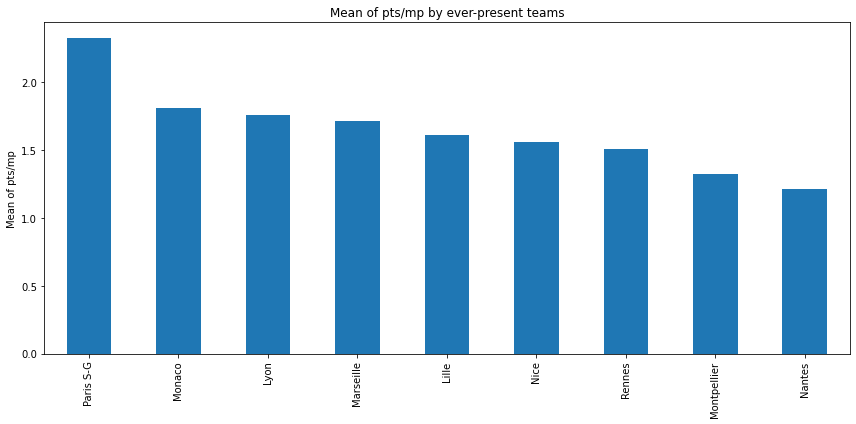

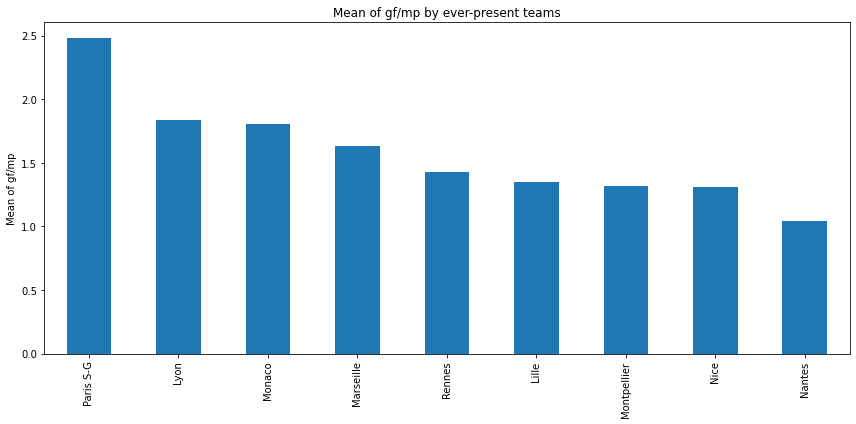

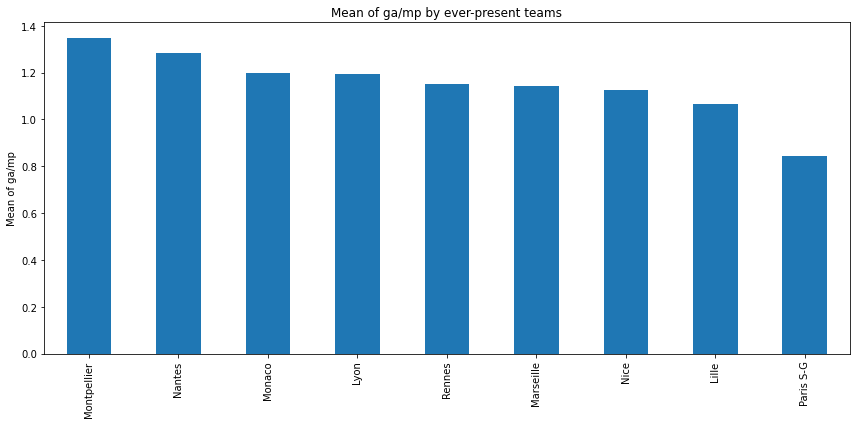

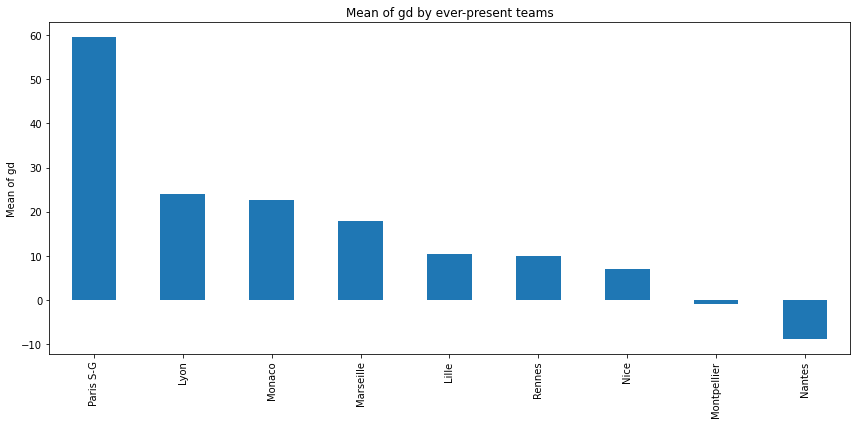

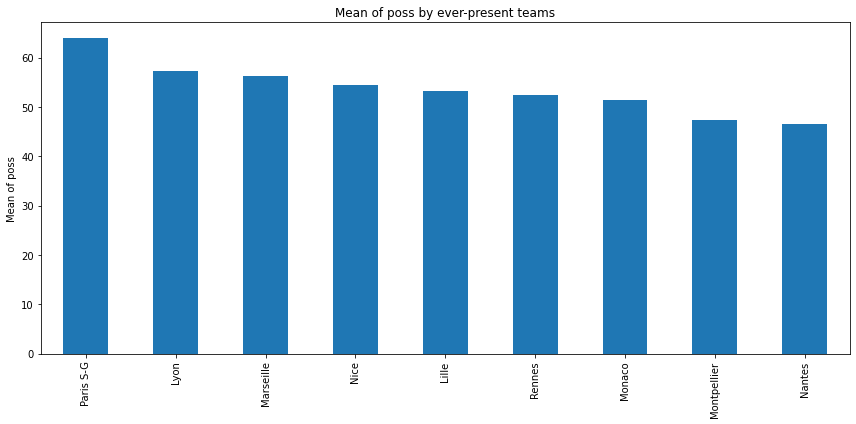

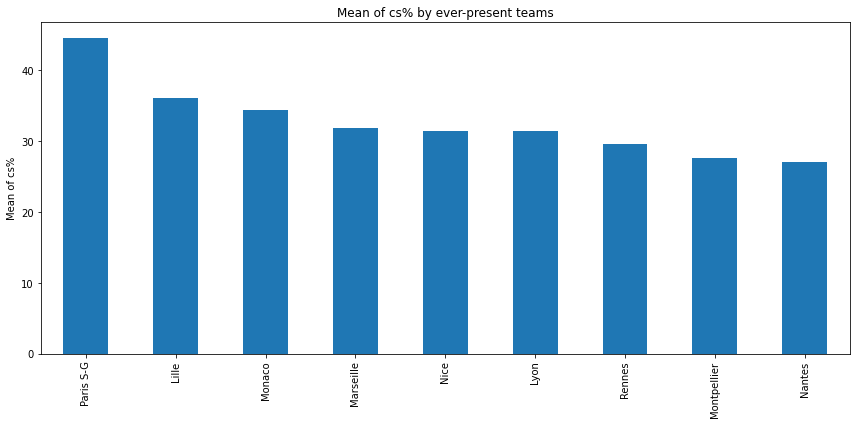

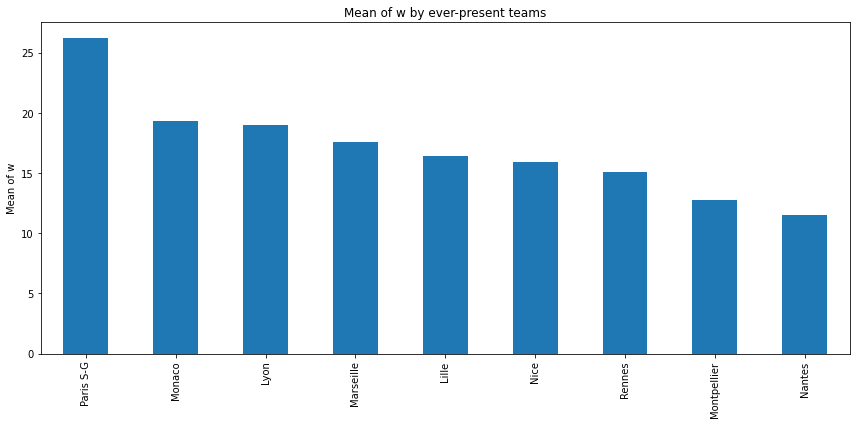

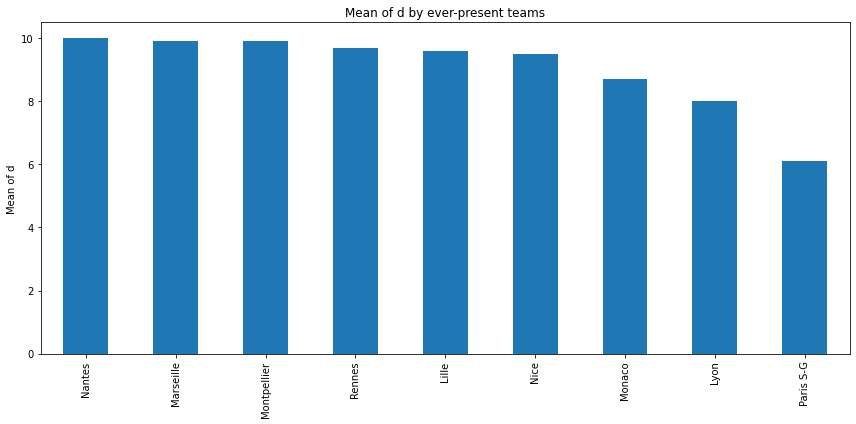

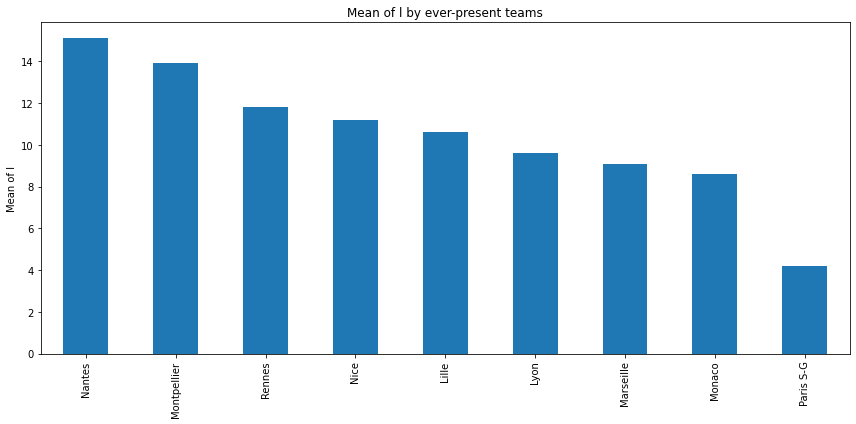

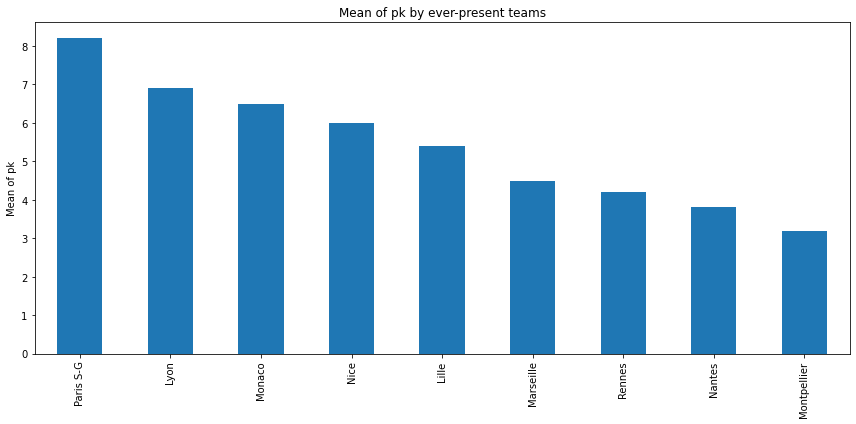

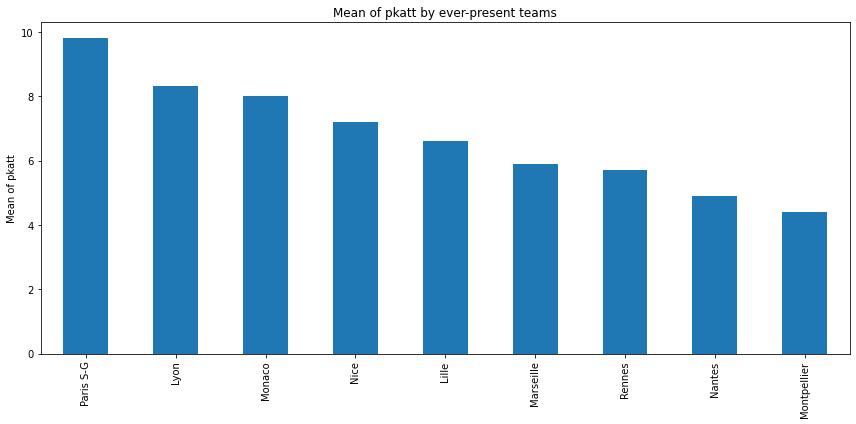

In [52]:
# Define the list of statistics we want to analyze per team
statistiques = ["pts/mp", "gf/mp", "ga/mp", "gd", "poss", "cs%", "w", "d", "l", "pk", "pkatt"]

# Filter the dataset to only include teams that were present in all seasons
df_clubs_toujours_present = df[df["team"].isin(clubs_toujours_present)]

# Dictionary to store average statistics per team
moyennes_par_equipe = {}

# Loop through each consistent team to calculate its average statistics across seasons
for equipe in df_clubs_toujours_present["team"].unique():
    # Subset the data for the specific team
    data_equipe = df_clubs_toujours_present[df_clubs_toujours_present["team"] == equipe]
    
    # Compute the mean of all numeric statistics for this team
    moyennes_equipe = data_equipe.mean(numeric_only=True)
    
    # Store the result in the dictionary
    moyennes_par_equipe[equipe] = moyennes_equipe

# Convert the dictionary to a DataFrame (teams as rows, stats as columns)
moyennes_equipe_df = pd.DataFrame(moyennes_par_equipe).T

# Loop over each selected stat to generate a sorted bar chart by team
for stat in statistiques:
    plt.figure(figsize=(12, 6))
    
    # Sort teams by average value for the given stat and plot a bar chart
    moyennes_equipe_df[stat].sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
    
    plt.title(f"Mean of {stat} by ever-present teams")
    plt.ylabel(f"Mean of {stat}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"../figures/stable_ranking_by_{stat.replace(f'/', '_')}.png", bbox_inches="tight", facecolor='white', dpi=300)
    plt.show()


### 📊 Mean of points / match played by ever-present teams

This chart displays the average number of points per match (pts/mp) for the ten most consistent clubs in Ligue 1 over the analyzed seasons.

🔎 **Key insights**:
- **Paris S-G** sits far above all others with over 2.3 points per match.
- **Monaco**, **Lyon**, and **Marseille** follow but with a noticeable gap.
- **Nantes** and **Montpellier** are at the bottom, indicating more modest performances among the ten.

---

### ⚽ Mean of goals for / match played by ever-present teams

This chart shows the average number of goals scored per match (gf/mp) by each of the ten consistently present teams.

🔎 **Key insights**:
- **Paris S-G** leads by a wide margin in offensive output.
- **Lyon** and **Monaco** rank second and third, reflecting consistent attacking prowess.
- **Nantes** is the least prolific, with barely more than 1 goal per match.

---

### 🛡️ Mean of goals against / match played by ever-present teams

This plot depicts the average number of goals conceded per match (ga/mp).

🔎 **Key insights**:
- **Paris S-G** once again dominates, with the most efficient defense.
- **Montpellier** and **Nantes** have the weakest defenses, conceding over 1.3 goals per match.
- Strong defense correlates with better overall rankings.

---

### ⚖️ Mean of goal difference by ever-present teams

This chart shows the average goal difference (gd) by team across all matches.

🔎 **Key insights**:
- **Paris S-G** is in a league of its own with an average goal difference nearing +60.
- Other clubs like **Lyon**, **Monaco**, and **Marseille** also maintain healthy margins.
- **Montpellier** and **Nantes** display negative or close-to-zero goal differentials, hinting at mid- or lower-table consistency.

---

### 🕹️ Mean of possession by ever-present teams

This bar chart represents the average possession rate per team across seasons.

🔎 **Key insights**:
- **Paris S-G** averages over 64% possession, well above the rest.
- **Lyon**, **Marseille**, and **Nice** also maintain high control of the ball.
- **Montpellier** and **Nantes** show more reactive styles, with lower average possession (~47%).

---

### 🧱 Mean of clean sheet % by ever-present teams

This chart shows the percentage of matches in which teams kept a clean sheet (cs%).

🔎 **Key insights**:
- **Paris S-G** again leads by a wide margin, underlining their defensive supremacy.
- **Lille** and **Monaco** also perform well defensively.
- **Montpellier** and **Nantes** rank lower in this metric, indicating frequent concessions.

---

### 🏆 Mean of wins by ever-present teams

This chart presents the average number of wins per season for each club.

🔎 **Key insights**:
- **Paris S-G** tops the list, averaging over 26 wins per season.
- **Monaco**, **Lyon**, and **Marseille** follow with ~19 wins.
- **Nantes** lags behind with just over 11 wins per season on average.

---

### 🤝 Mean of draws by ever-present teams

This plot shows the average number of draws per season for each team.

🔎 **Key insights**:
- **Nantes** and **Marseille** record the most draws, suggesting tighter matches.
- **Paris S-G** records the fewest draws, reflecting more decisive outcomes (usually wins).

---

### ❌ Mean of losses by ever-present teams

This bar chart shows the average number of losses per team per season.

🔎 **Key insights**:
- **Paris S-G** is by far the most consistent in avoiding defeats.
- **Nantes** and **Montpellier** suffer the most losses among the top 10.
- Low loss rates align closely with overall performance standings.

---

### 🎯 Mean of penalties scored by ever-present teams

This chart displays the average number of penalty goals per season.

🔎 **Key insights**:
- **Paris S-G**, **Lyon**, and **Monaco** lead the ranking, reflecting their frequent presence in the opponent’s box.
- **Montpellier** and **Nantes** trail behind, with fewer penalty opportunities or conversions.

---

### 🎯 Mean of penalties attempted by ever-present teams

This chart illustrates how often each team attempted penalties on average.

🔎 **Key insights**:
- **Paris S-G** leads once again, followed by **Lyon** and **Monaco**, indicating regular penalty opportunities.
- **Montpellier** and **Nantes** attempt the fewest penalties, reflecting limited offensive penetration or box presence.

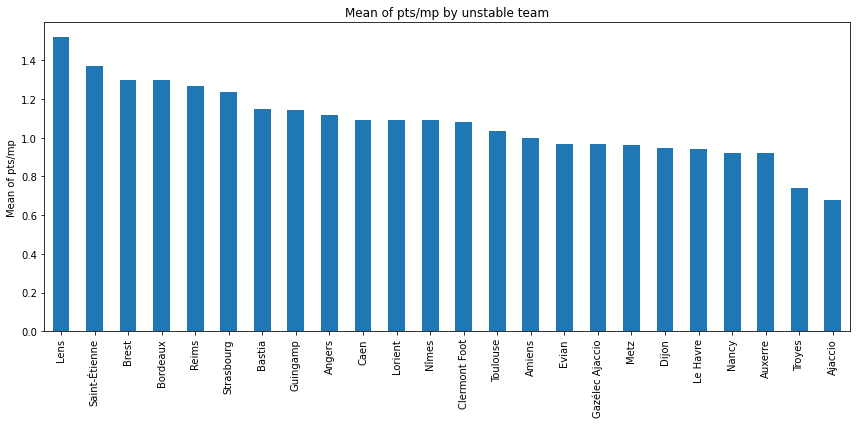

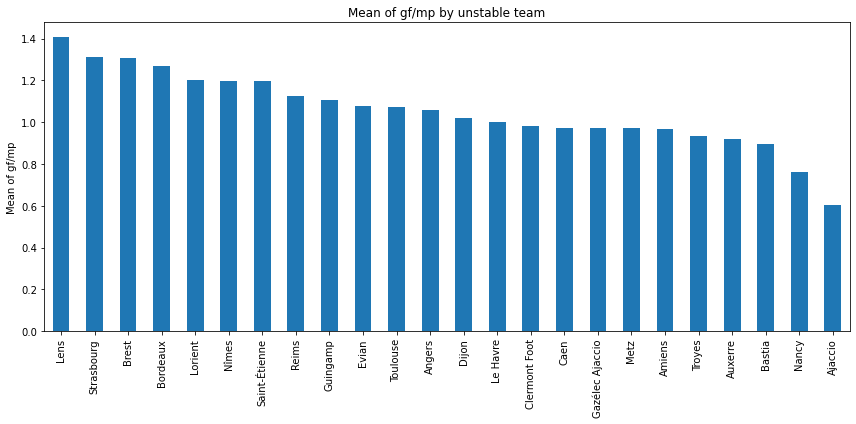

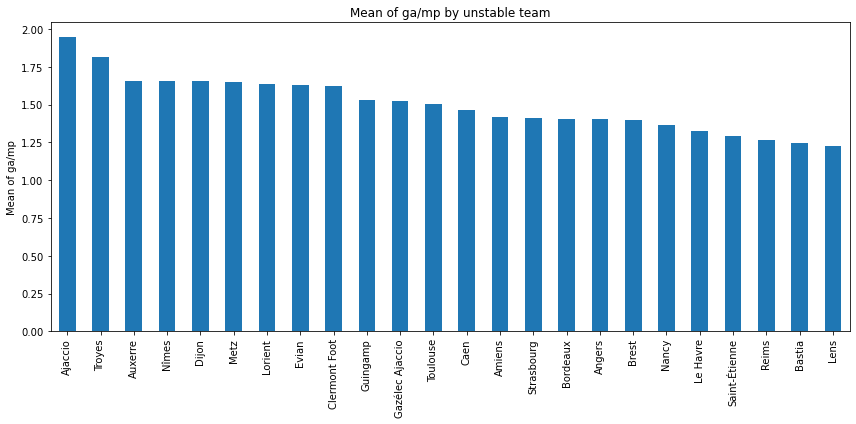

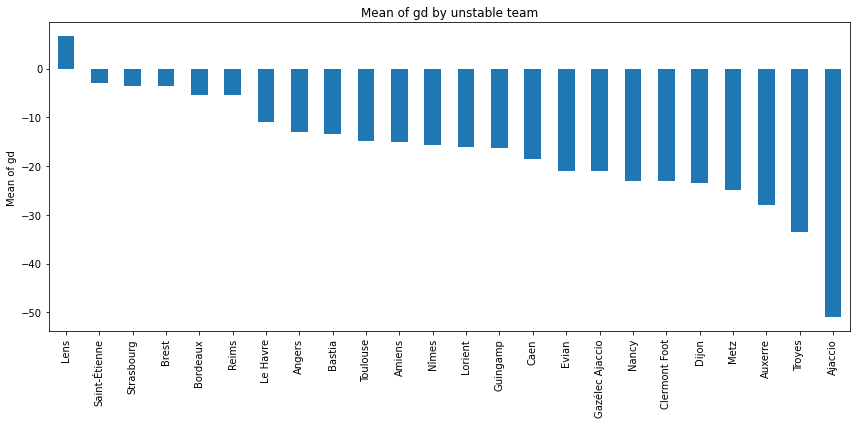

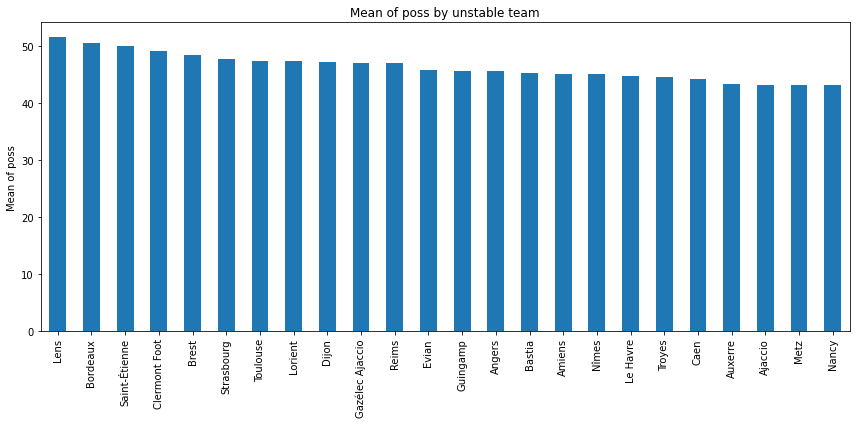

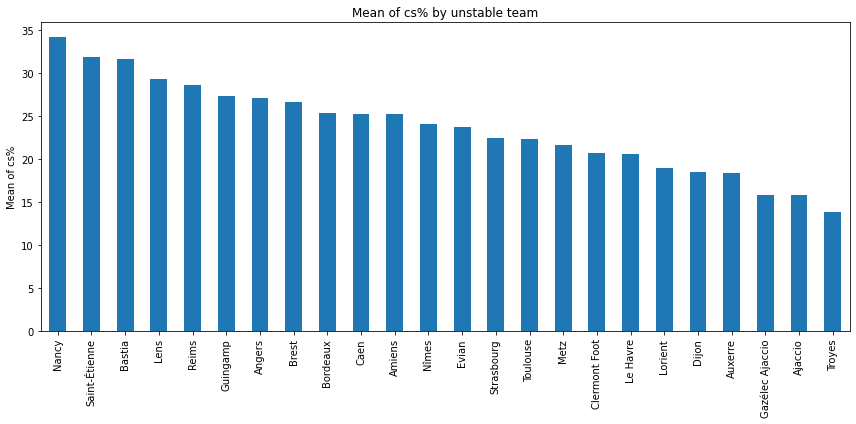

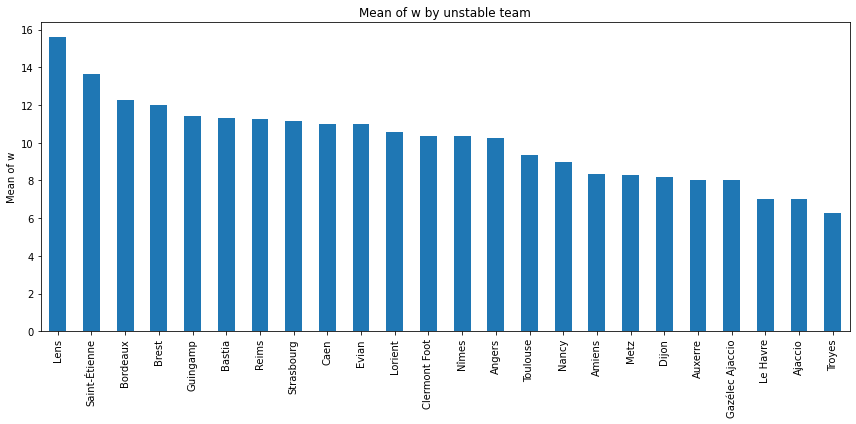

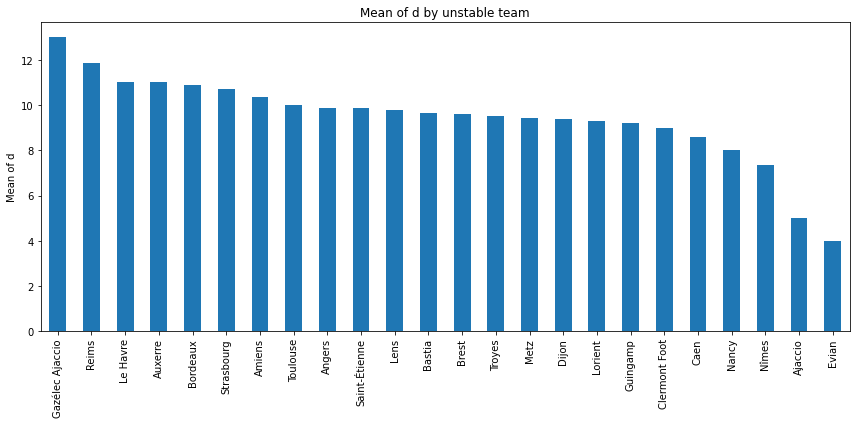

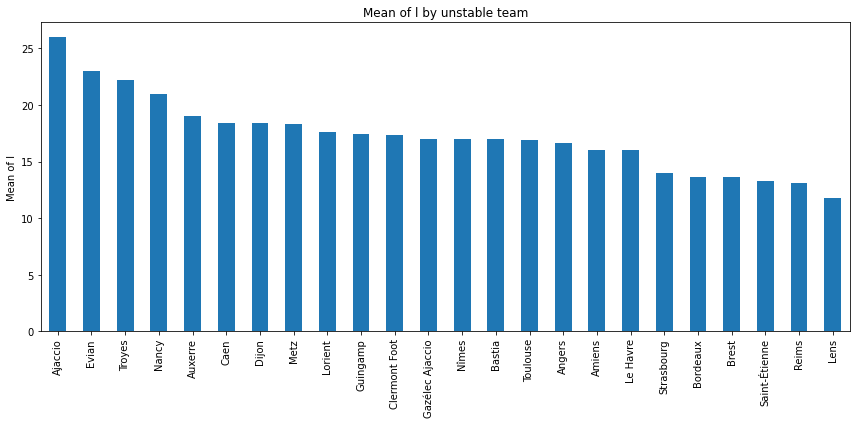

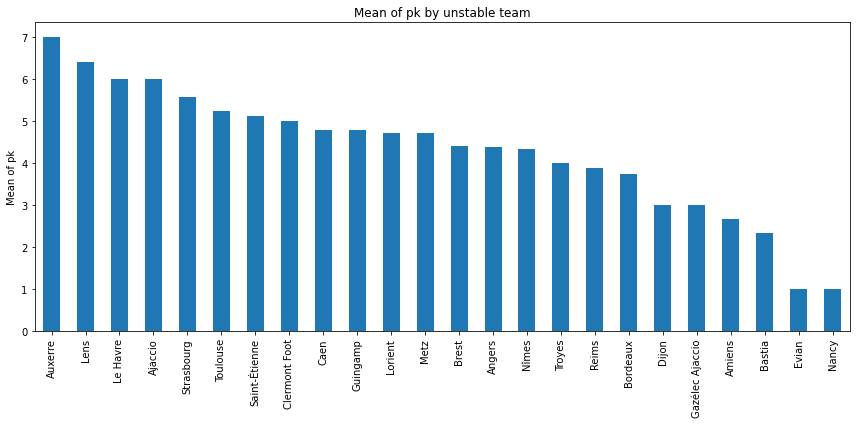

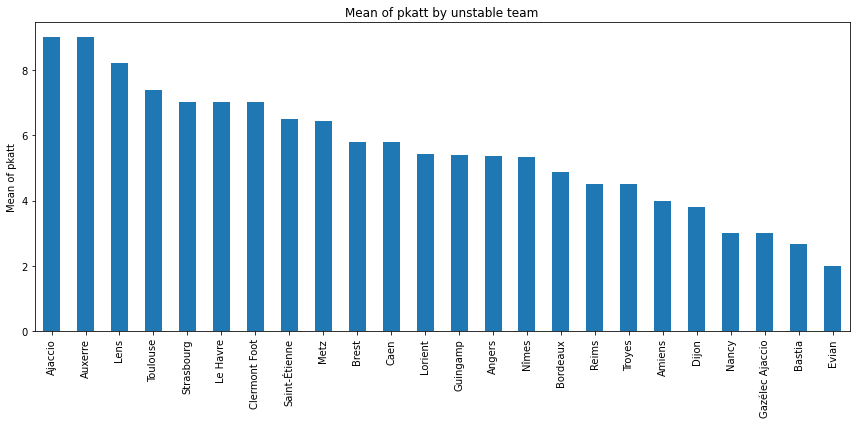

In [51]:
# Apply the same code for the teams that have been relegated at least once or promoted across the stretch

statistiques = ["pts/mp", "gf/mp", "ga/mp", "gd", "poss", "cs%", "w", "d", "l", "pk", "pkatt"]

df_clubs_toujours_present = df[~df["team"].isin(clubs_toujours_present)]

moyennes_par_equipe = {}

for equipe in df_clubs_toujours_present["team"].unique():
    data_equipe = df_clubs_toujours_present[df_clubs_toujours_present["team"] == equipe]
    
    moyennes_equipe = data_equipe.mean(numeric_only=True)
    
    moyennes_par_equipe[equipe] = moyennes_equipe

moyennes_equipe_df = pd.DataFrame(moyennes_par_equipe).T

for stat in statistiques:
    plt.figure(figsize=(12, 6))
    moyennes_equipe_df[stat].sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
    plt.title(f"Mean of {stat} by unstable team")
    plt.ylabel(f"Mean of {stat}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"../figures/unstable_ranking_by_{stat.replace(f'/', '_')}.png", bbox_inches="tight", facecolor='white', dpi=300)
    plt.show()

### 📊 Mean of points / match played by team across the stretch

This bar chart shows the average number of points per match (pts/mp) earned by each team during the analyzed period.

🔎 **Key insights**:
- **Lens** stands out as the top performer in terms of points per game.
- Teams like **Ajaccio** and **Troyes** are at the bottom, with the lowest averages, indicating consistent underperformance.
- There's a clear gap between high-performing teams and the rest, showing that a few teams manage to maintain a higher level of performance.

---

### ⚽ Mean of goals for / match played  by team across the stretch

This chart visualizes the average number of goals scored per match (gf/mp) by each team.

🔎 **Key insights**:
- **Lens** also tops the chart for offensive output, reinforcing their strong overall performance.
- Teams like **Ajaccio** and **Nancy** struggle to score, with low goal-per-game averages.
- **Strasbourg** and **Brest** rank surprisingly high in goal output, suggesting offensive strength despite mixed overall results.

---

### 🛡️ Mean of goals against / match played by team across the stretch

This plot depicts the average number of goals conceded per match (ga/mp) by each club.

🔎 **Key insights**:
- **Ajaccio** and **Troyes** have the weakest defenses, conceding close to or above 2 goals per match.
- **Lens** boasts the best defensive record, followed closely by **Bastia** and **Reims**.
- A strong defensive structure is clearly linked to better overall standings.

---

### ⚖️ Mean of goal difference by team across the stretch

This chart summarizes the goal difference (goals scored - goals conceded) across all matches.

🔎 **Key insights**:
- **Lens** is the only team with a substantially positive goal difference.
- Many clubs hover around zero or below, indicating issues in converting goals into dominance.
- **Ajaccio** and **Troyes** have particularly alarming negative goal differences.

---

### 🕹️ Mean of possession by team across the stretch

This chart shows average ball possession per team, as a percentage of total time.

🔎 **Key insights**:
- **Lens**, **Bordeaux**, and **Saint-Étienne** lead in possession metrics, hinting at control-oriented styles.
- The bottom teams (e.g. **Nancy**, **Metz**) tend to cede control, likely focusing on reactive strategies.

---

### 🧱 Mean of clean sheet % by team across the stretch

This bar chart reflects the clean sheet percentage (cs%) — the proportion of games in which a team didn’t concede.

🔎 **Key insights**:
- **Nancy**, **Saint-Étienne**, and **Bastia** emerge as the most effective defensive units in terms of keeping clean sheets.
- Teams like **Troyes** and **Ajaccio** are less reliable defensively, rarely managing to keep opponents scoreless.

---

### 🏆 Mean of wins by team across the stretch

This graph shows the average number of wins per season for each team.

🔎 **Key insights**:
- **Lens** and **Saint-Étienne** lead with the most wins on average.
- At the other end, **Troyes** and **Ajaccio** have notably fewer victories.
- Winning consistently appears to align with other indicators like goal difference and offensive output.

---

### 🤝 Mean of drawns by team across the stretch

This chart shows the average number of draws per season.

🔎 **Key insights**:
- **Gazélec Ajaccio** and **Reims** draw the most often, indicating conservative or balanced match outcomes.
- **Evian**, **Ajaccio**, and **Troyes** tend to have fewer draws, often ending matches with wins or losses.

---

### ❌ Mean of loss by team across the stretch

This graph shows the average number of losses per season.

🔎 **Key insights**:
- **Ajaccio**, **Evian**, and **Troyes** are the most frequent losers, correlating with their low pts/mp and gd.
- **Lens** again appears on the other end, showcasing their consistency in avoiding defeat.

---

### 🎯 Mean of penalty scored by team across the stretch

This chart illustrates the average number of penalties scored by each team.

🔎 **Key insights**:
- **Auxerre** and **Lens** benefit from a significant number of penalty goals.
- **Nancy** and **Evian** are rarely awarded penalties or fail to convert them, reducing their offensive options.

---

### 🎯 Mean of penalty attempted by team across the stretch

This final plot displays the average number of penalty attempts per season.

🔎 **Key insights**:
- **Ajaccio** and **Auxerre** obtain the most penalties on average, but this may also reflect attacking styles or referee decisions.
- The teams at the bottom of the list rarely get the opportunity to score from the penalty spot, which may impact goal efficiency metrics.

---

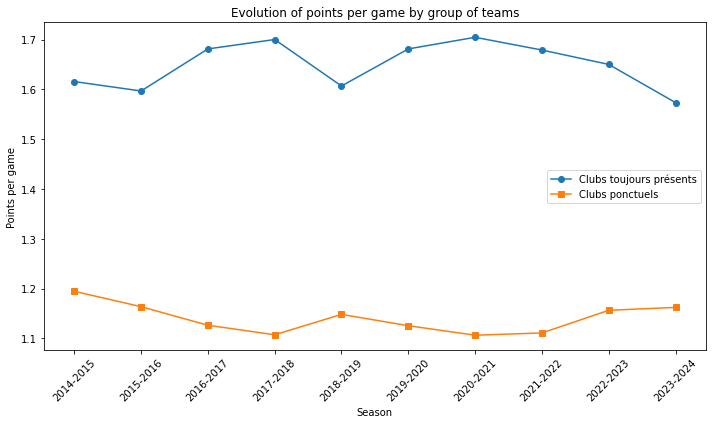

In [56]:
# Create an empty list to store average points per game per group per season
moyennes_saison = []

# Loop through each season in the dataset
for saison in df["season"].unique():
    # Subset the data for the current season
    df_saison = df[df["season"] == saison]
    
    # Separate the data into two groups:
    # - teams that have always been in Ligue 1
    # - other teams (promoted/relegated)
    clubs_toujours = df_saison[df_saison["team"].isin(clubs_toujours_present)]
    clubs_ponctuels = df_saison[~df_saison["team"].isin(clubs_toujours_present)]
    
    # Compute the average points per match for each group
    moyenne_toujours = clubs_toujours["pts/mp"].mean()
    moyenne_ponctuels = clubs_ponctuels["pts/mp"].mean()
    
    # Store the values in a dictionary, one per season
    moyennes_saison.append({
        "saison": saison,
        "clubs_toujours": moyenne_toujours,
        "clubs_ponctuels": moyenne_ponctuels
    })

# Convert the list of dictionaries into a DataFrame for plotting
df_moyennes = pd.DataFrame(moyennes_saison).sort_values("saison")

# Plot the evolution of points per match for both groups of clubs
plt.figure(figsize=(10, 6))

# Line for long-term clubs
plt.plot(
    df_moyennes['saison'].values,
    df_moyennes['clubs_toujours'].values,
    label="Clubs toujours présents",
    marker='o'
)

# Line for temporary clubs
plt.plot(
    df_moyennes['saison'].values,
    df_moyennes['clubs_ponctuels'].values,
    label="Clubs ponctuels",
    marker='s'
)

plt.title("Evolution of points per game by group of teams")
plt.xlabel("Season")
plt.ylabel("Points per game")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("../figures/points_by_club_type.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()


This plot compares the evolution of **average points per game (Pts/MP)** between two categories of clubs:

- **"Established clubs"**: Teams that have competed in Ligue 1 without interruption from 2014–2015 to 2023–2024.
- **"Unstable clubs"**: Teams that have been promoted or relegated during this period.

---

### 🔍 Observations:
- **Established clubs** consistently average between **1.6 and 1.7 points per match**, a performance level close to top-half standings.
- In contrast, **unstable clubs** remain stuck around **1.1–1.2 points per match**, corresponding to **relegation-threatened form**.
- The gap is particularly wide during the **2016–2018** and **2020–2022** periods, indicating seasons where elite clubs further solidified their dominance.

---

### 📌 Interpretation:
This disparity highlights the structural challenge of staying in Ligue 1:
- **Regular participants benefit** from squad continuity, greater budgets, and top-tier infrastructure.
- **Promoted teams struggle** to bridge the performance gap, suggesting the league’s competitive ceiling is hard to breach without sustained resources and long-term planning.

This trend supports the idea of a **"two-speed Ligue 1"**, where the top tier stabilizes while newcomers face uphill battles for survival.


## 📈 2. Evolution of Ligue 1 Performance Over Time

This section explores:
- The overall trends in possession, goals scored, and average points
- The performance trajectories of specific clubs (PSG, Lyon, Monaco) across multiple seasons
- The relative stability or volatility of league rankings over time

🔍 These insights help visualize changes in the league’s average level and the dominance of certain clubs.
    

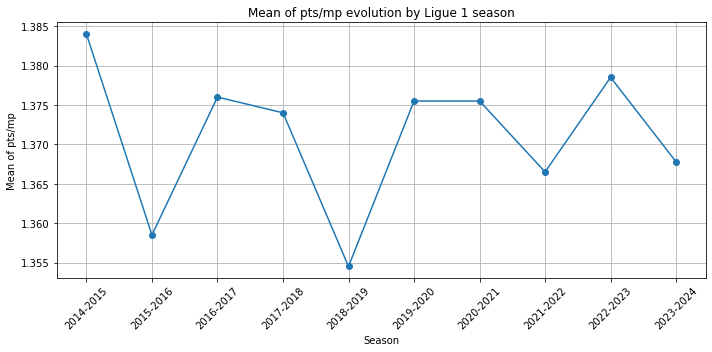

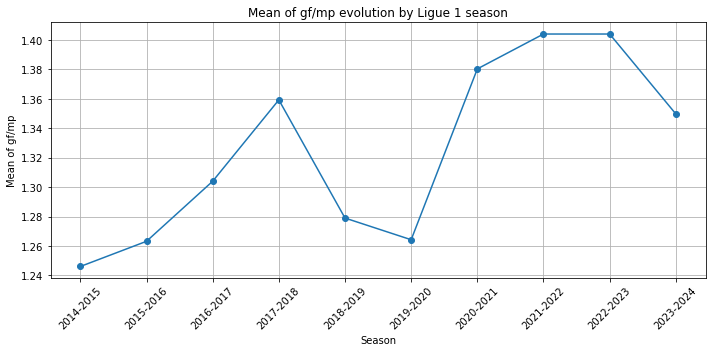

In [50]:
# Define the list of performance statistics to analyze over time
stats = ["pts/mp", "gf/mp"]

# Group the dataset by season and compute the average of each selected stat
evolution_generale = df.groupby("season")[stats].mean().reset_index()

# Plot the evolution of each stat over time
for stat in stats:
    plt.figure(figsize=(10, 5))
    
    # Plot stat trend line across seasons
    plt.plot(
        evolution_generale["season"].values,
        evolution_generale[stat].values,
        marker='o'
    )
    
    plt.title(f"Mean of {stat} evolution by Ligue 1 season")
    plt.xlabel("Season")
    plt.ylabel(f"Mean of {stat}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../figures/evolution_general_{stat.replace(f'/', '_')}.png", bbox_inches="tight", facecolor='white', dpi=300)
    plt.show()


This series of plots captures the **average values** of key performance metrics across all Ligue 1 teams for each season, offering a macro view of the league’s evolution.

---

### 📊 1. Average Points per Match (`pts/mp`)
- The mean points per team per match stays relatively **stable**, hovering around **1.36–1.38**.
- Slight fluctuations are visible in **2018–2019** and **2020–2021**, possibly reflecting outlier performances or disruptions (e.g. COVID).
- ⚖️ This stability is expected in a closed league system where the sum of wins, draws, and losses across all matches is constant.

---

### ⚽ 2. Average Goals per Match (`gf/mp`)
- A **clear upward trend** emerges after 2018–2019, with peak levels in **2021–2022** and **2022–2023** reaching ~1.40.
- This may reflect tactical shifts toward more attacking play, or the growing influence of dominant attacking teams (e.g. PSG, Monaco).
- 🧮 This metric directly influences entertainment value and league competitiveness.

---


### ✅ Takeaway:
While the overall **points distribution** remains constant, the league has seen a **clear rise in attacking output**. This trend reflects a shift toward a more open and potentially entertaining style of play, driven by strategic evolution and offensive talent concentration — especially among top-tier clubs.


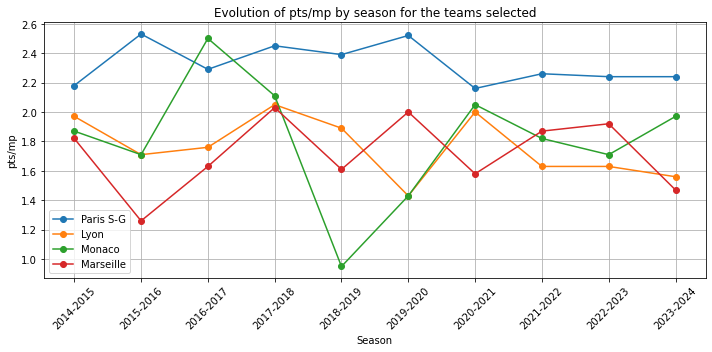

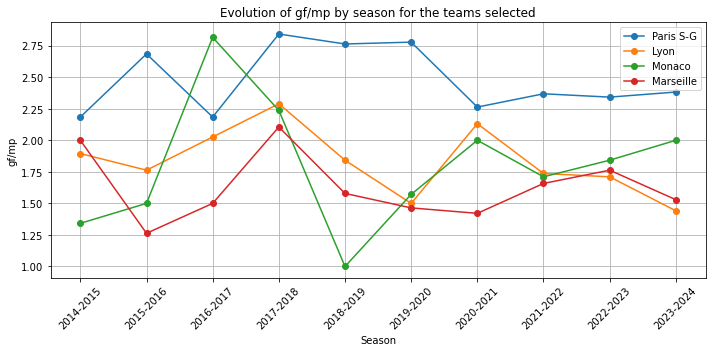

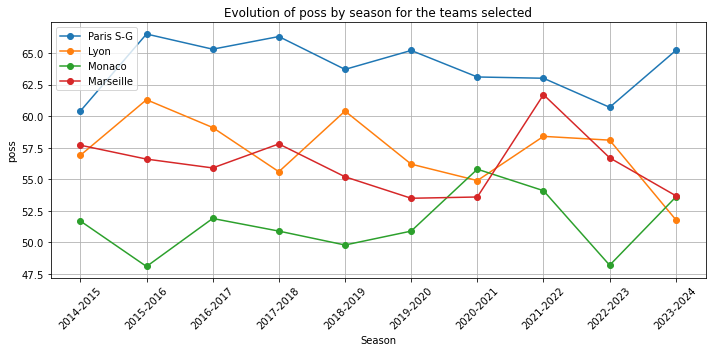

In [49]:
# Define the list of high-profile teams to follow across seasons
clubs_suivis = ["Paris S-G", "Lyon", "Monaco", "Marseille"]

# Define the performance metrics to track
stats = ["pts/mp", "gf/mp", "poss"]

# Loop over each stat to create a time-series comparison for the selected clubs
for stat in stats:
    plt.figure(figsize=(10, 5))
    
    for club in clubs_suivis:
        # Subset the data for the current club and sort by season
        data_club = df[df["team"] == club].sort_values("season")
        
        # Plot the stat's evolution for this club
        plt.plot(
            data_club["season"].values,
            data_club[stat].values,
            label=club,
            marker='o'
        )
    
    # Customize and display the plot
    plt.title(f"Evolution of {stat} by season for the teams selected")
    plt.xlabel("Season")
    plt.ylabel(stat)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../figures/evolution_{stat.replace(f'/', '_')}.png", bbox_inches="tight", facecolor='white', dpi=300)
    plt.show()


This section tracks the year-over-year evolution of three key metrics — **points per match**, **goals per match**, and **possession** — for four of the most prominent Ligue 1 clubs: **Paris Saint-Germain, Lyon, Monaco, and Marseille**.

---

### 🟦 Points per Match (`pts/mp`)
- **PSG** exhibits unmatched consistency, with nearly all seasons above 2.2 points per game — a benchmark of title-winning form.
- **Lyon and Marseille** show intermittent success, fluctuating around the 1.5–2.0 range.
- **Monaco** peaks in **2016–2017** with a spectacular title-winning season (2.5 pts/mp), followed by dramatic volatility, including a steep drop in **2018–2019** (0.9).

📊 **Conclusion:** PSG’s regularity contrasts with the more erratic performances of its rivals, highlighting the challenge of maintaining elite-level success over time.

---

### 🔴 Goals For per Match (`gf/mp`)
- PSG consistently scores **2.2–2.8 goals per game**, making them the league’s offensive juggernaut.
- Monaco’s attacking explosion in **2016–2017** (almost 2.8 gf/mp) was historically remarkable.
- Marseille and Lyon show more typical elite offense (1.5–2.0 gf/mp) with slight seasonal variance.

⚽ **Conclusion:** Goal-scoring surges (e.g., Monaco 16/17) often coincide with title runs, while dips in this metric can explain underperformance.

---

### 🟡 Possession (`poss`)
- PSG again leads the pack with possession consistently over **63%**, reinforcing their dominance through ball control.
- Lyon regularly maintains **58–60%**, reflecting their traditional control-based style.
- Monaco and Marseille vary more in style, with dips in possession during transitional years or tactical shifts.

🔍 **Conclusion:** While possession alone doesn’t determine success, it is a defining trait of sustained top-tier clubs like PSG and Lyon.

---

### 📌 Final Insight:
This temporal lens reveals both **strategic identities** and **cyclical performance shifts**. Consistent high-level teams like PSG exhibit statistical stability, whereas clubs like Monaco show more pronounced **high-risk/high-reward patterns**.



## 📊 3. Variability of Team Rankings

The final league ranking (`LgRank`) was converted into a numerical score in order to:
- Calculate the average and standard deviation of each team’s final ranking across seasons
- Identify the most consistent clubs versus the most volatile ones

📌 Teams located in the bottom-left quadrant (low average rank and low standard deviation) are the most dominant and stable performers.
    

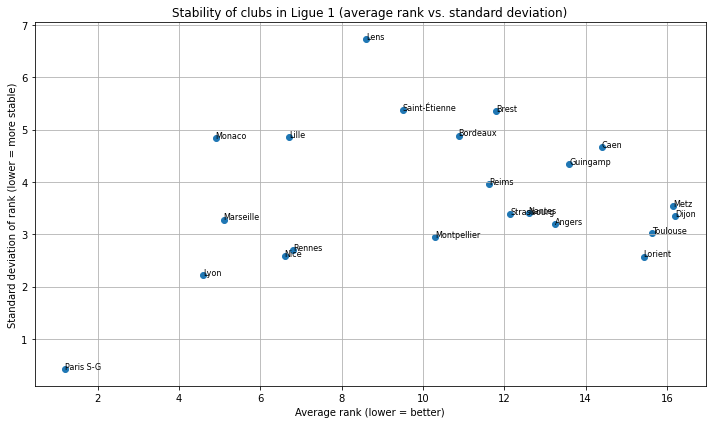

In [48]:
# Convert the final league rank ('LgRank') from string format (e.g., '1st', '12th') to numeric
df["LgRank_num"] = df["lgrank"].str.extract(r'(\d+)').astype(int)

# Group by team to compute rank-related statistics
rang_stats = df.groupby("team").agg(
    moyenne_rang=("LgRank_num", "mean"),        # Mean final rank over all seasons
    ecart_type_rang=("LgRank_num", "std"),      # Standard deviation of final rank (variation)
    saisons_jouees=("season", "count")          # Number of seasons the team appeared in
).reset_index()

# Only keep teams that have played at least 5 seasons (for more reliable statistics)
rang_stats_filtre = rang_stats[rang_stats["saisons_jouees"] >= 5]

# Create a scatter plot comparing average rank vs. rank standard deviation
plt.figure(figsize=(10, 6))
plt.scatter(
    rang_stats_filtre["moyenne_rang"],
    rang_stats_filtre["ecart_type_rang"]
)

# Label each point with the corresponding team name
for i, row in rang_stats_filtre.iterrows():
    plt.text(
        row["moyenne_rang"],
        row["ecart_type_rang"],
        row["team"],
        fontsize=8
    )

# Customize the plot
plt.title("Stability of clubs in Ligue 1 (average rank vs. standard deviation)")
plt.xlabel("Average rank (lower = better)")
plt.ylabel("Standard deviation of rank (lower = more stable)")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../figures/stability.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()


This scatter plot evaluates the **stability** of Ligue 1 clubs by comparing their **average final rank** to the **standard deviation of that rank**, using only clubs with **at least 5 seasons** in the dataset (2014–2024).

### 🧠 Interpretation:
- **X-axis:** Average league rank (lower is better)
- **Y-axis:** Standard deviation of rank (lower is more stable)

---

### 🔝 Consistent Performers:
- **Paris S-G** is the clear outlier — not only achieving the **best average rank**, but doing so with **minimal variation** (≈0.5 std dev). Pure dominance.
- **Lyon and Marseille** follow with consistently strong results and relatively low rank variability — signaling reliable high-level performance.
- **Monaco and Lille** perform well on average but with higher variability, possibly reflecting more volatile squad cycles or season-to-season disruptions.

---

### 🔄 Volatile Teams:
- **Lens** and **Saint-Étienne** show some of the highest standard deviations, indicating **large fluctuations** in league finishes.
- **Bordeaux, Reims, Caen**, and others also exhibit considerable instability, with seasons ranging from mid-table comfort to relegation danger.

---

### 🎯 Takeaway:
This plot helps identify which clubs are not just **successful**, but also **reliable** over time — a key insight for long-term project planning, recruitment strategy, or even forecasting. Stability is a competitive advantage in itself.



## ⚔️ 4. Statistical Comparison of Clubs

Two types of comparisons were performed:
- **Average over the full period**: Possession, goals scored, and clean sheet percentage
- **Radar charts**: A synthetic visualization of the performance profiles of the top-performing clubs

Radar charts were normalized to ensure clarity and consistency in visual comparisons.
    

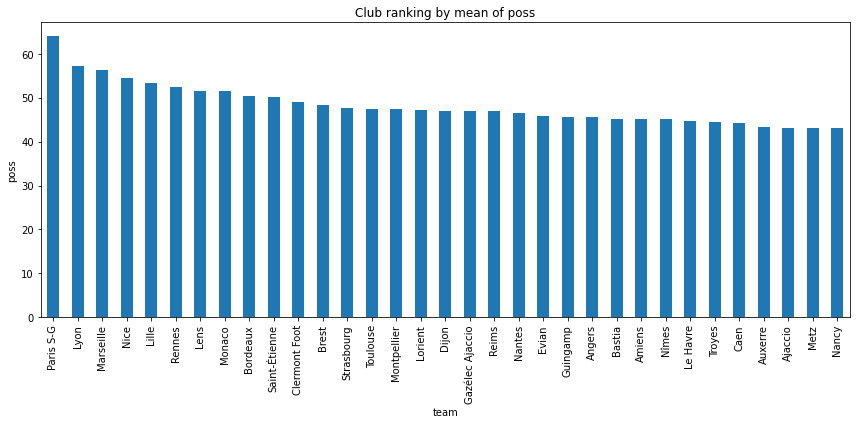

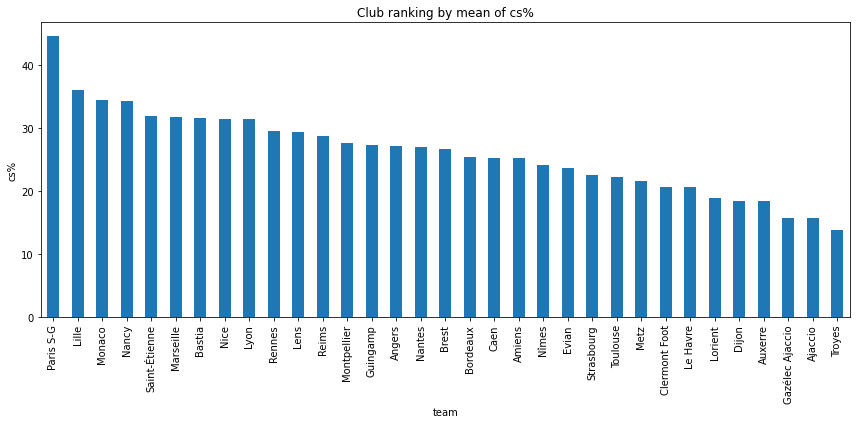

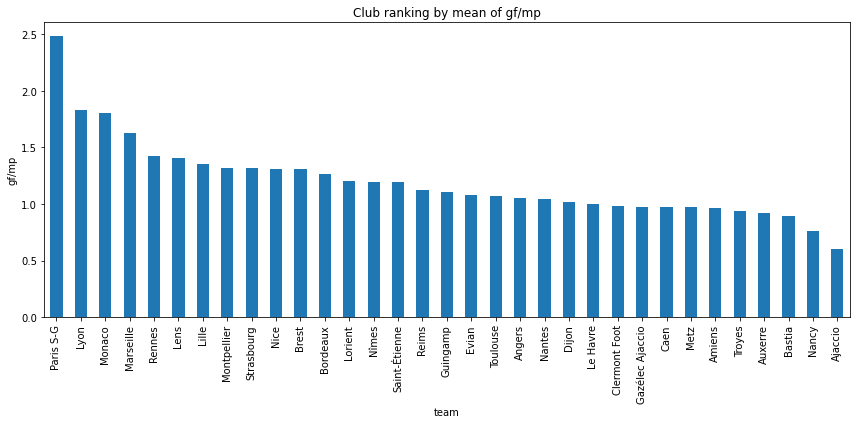

In [47]:
# Compute the average values of key performance stats per team
# We're focusing on: possession, clean sheet percentage, and goals per match
stats_classement = df.groupby("team")[["poss", "cs%", "gf/mp"]].mean().sort_values("gf/mp", ascending=False)

# For each stat, generate a bar chart sorted by average value
for stat in stats_classement.columns:
    plt.figure(figsize=(12, 6))
    
    # Sort clubs by their average value for the current stat
    stats_classement[stat].sort_values(ascending=False).plot(kind="bar")
    
    plt.title(f"Club ranking by mean of {stat}")
    plt.ylabel(stat)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"../figures/club_ranking_by_{stat.replace(f'/', '_')}.png", bbox_inches="tight", facecolor='white', dpi=300)
    plt.show()


The following bar charts rank Ligue 1 clubs by their **average performance** over the 2015–2024 period, using three fundamental indicators:

---

### 🔵 1. Possession (%)
- **Paris Saint-Germain** leads convincingly, averaging over **63%** — a reflection of their sustained dominance in ball control.
- **Lyon, Marseille, and Nice** also rank highly, showing tactical preferences for building through possession.
- Lower-ranked teams such as **Metz, Ajaccio, and Nancy** tend to concede possession, possibly due to reactive or defensive styles.

➡️ Possession alone doesn’t guarantee success, but it correlates with team identity and strategic intent.

---

### 🟢 2. Clean Sheet Percentage (`cs%`)
- Again, **PSG** tops the list with over **45%** of matches ending without conceding — confirming their defensive strength.
- **Lille and Monaco** follow, validating their reputation for structured backlines during their best seasons.
- Teams like **Troyes and Ajaccio** sit at the bottom, which aligns with their frequent relegation battles and instability.

🛡️ This metric reflects **defensive discipline and goalkeeper reliability**.

---

### 🔴 3. Goals For per Match (`gf/mp`)
- PSG’s attacking firepower places them far ahead of the pack with close to **2.5 goals per match**.
- **Lyon, Monaco, and Marseille** also boast strong offensive output.
- In contrast, clubs like **Ajaccio, Nancy, and Brest** struggle to reach even one goal per game on average.

⚽ Offensive firepower is a key differentiator among elite clubs and appears tightly linked with Top 3 finishes.

---

### 🎯 Takeaway:
These rankings give a **clear picture of each club’s tactical profile** over nearly a decade. Clubs consistently near the top across all three metrics — especially PSG, Lyon, and Monaco — tend to dominate Ligue 1, while others reveal more specialized strengths or structural weaknesses.


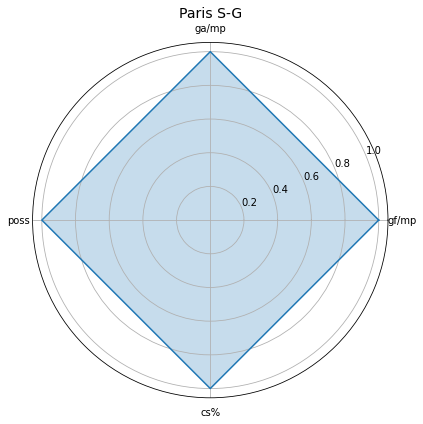

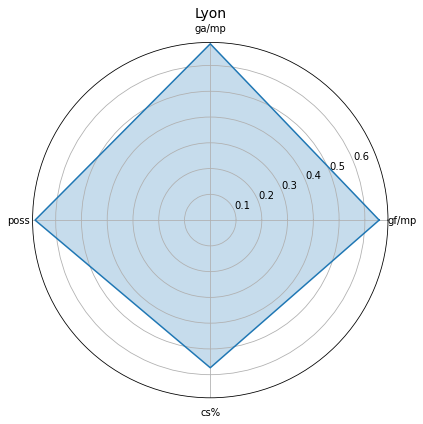

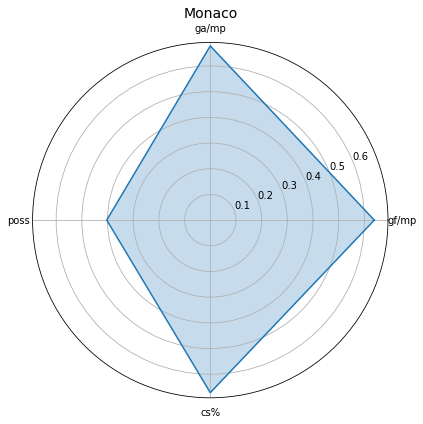

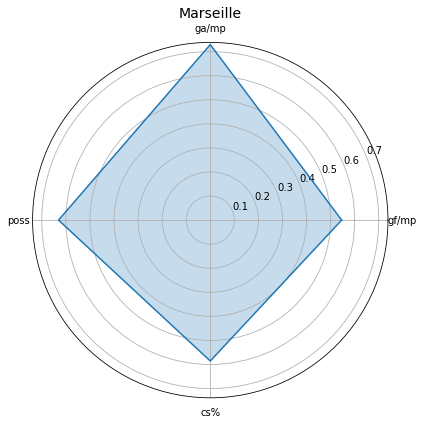

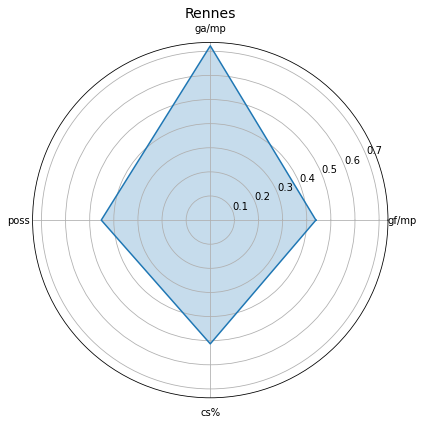

In [45]:
# Define the statistics to be displayed in radar charts
stats_radar = ["gf/mp", "ga/mp", "poss", "cs%"]

# Compute the average of each stat per team across all seasons
df_radar = df.groupby("team")[stats_radar].mean()

# Invert the defensive stat "ga/mp" so that lower goals conceded is scored higher
df_radar["ga/mp"] = df_radar["ga/mp"].max() - df_radar["ga/mp"]

# Normalize each stat between 0 and 1 to prepare for radar chart display
df_radar_norm = df_radar.copy()
for col in stats_radar:
    min_val = df_radar[col].min()
    max_val = df_radar[col].max()
    df_radar_norm[col] = (df_radar[col] - min_val) / (max_val - min_val)

# Select top 5 clubs based on average goals scored per match
top_clubs = df_radar.sort_values("gf/mp", ascending=False).head(5)

# Function to plot a radar chart for a given club
def plot_radar(data, club_name):
    values = data.loc[club_name].values
    labels = data.columns
    num_vars = len(labels)
    
    # Compute angles for each axis of the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # Complete the loop by repeating the first value
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    # Create polar plot (radar chart)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, label=club_name)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(club_name, size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.tight_layout()
    plt.savefig(f"../figures/radar_chart_{club_name.replace(' ', '_')}.png", bbox_inches="tight", facecolor='white', dpi=300)
    plt.show()

# Plot radar charts for each of the top 5 clubs
for club in top_clubs.index:
    plot_radar(df_radar_norm, club)



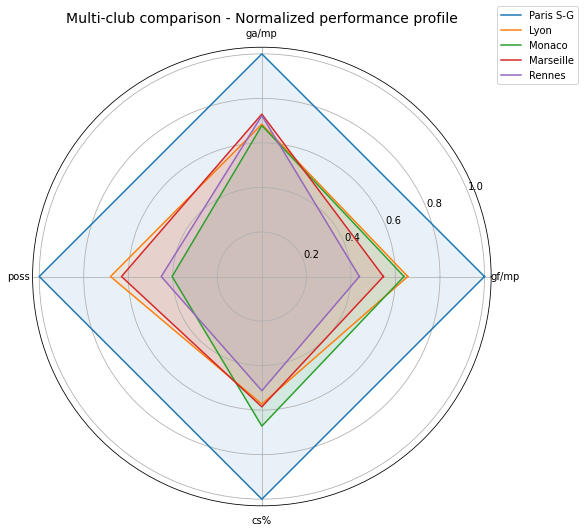

In [55]:
# Compute all the teams in a single radar chart representation

clubs_comparaison = ["Paris S-G", "Lyon", "Monaco", "Marseille", "Rennes"]

labels = stats_radar
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for club in clubs_comparaison:
    values = df_radar_norm.loc[club].tolist()
    values += values[:1]  
    ax.plot(angles, values, label=club)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Multi-club comparison - Normalized performance profile", size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.savefig(f"../figures/radar_multi_club.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()

This radar chart compares five top Ligue 1 teams — **Paris Saint-Germain, Lyon, Monaco, Lille, and Rennes** — across four key normalized metrics:

- `gf/mp`: Goals For per Match
- `ga/mp`: Goals Against per Match (inverted for comparison)
- `poss`: Average Possession
- `cs%`: Clean Sheet Percentage

### 🔍 Key Insights:

- **Paris S-G** (blue) dominates the chart on every axis. Their performance profile is **close to maximum** across all dimensions, especially in offensive power and possession.
- **Lyon** (orange) shows a strong attacking profile with decent clean sheet rates and high possession, forming a well-balanced shape.
- **Monaco** (green) performs well in offense (`gf/mp`) and clean sheets (`cs%`), but shows weaker possession stats.
- **Lille** (red) stands out for **defensive solidity** (`cs%`) but underperforms offensively compared to its rivals — indicative of a pragmatic style.
- **Rennes** (purple) displays a more modest profile, competitive across the board but without peaks — signaling consistency rather than dominance.

📊 This visual format highlights not only how strong each club is, but **how** they succeed — whether through offense, defense, control, or balance. It's particularly helpful for distinguishing tactical identities.



## 🔁 5. Correlation Analysis

Specific correlations explored:
- Possession vs. Points
- Goals scored vs. Points
- Clean Sheets vs. Final Ranking

A correlation heatmap was used to visualize all relationships between variables.

🎯 Objective: identify which statistics are most strongly associated with team performance.

    

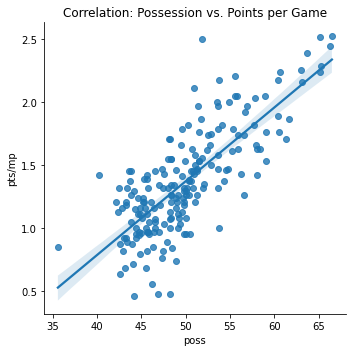

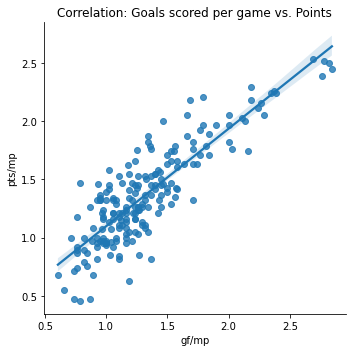

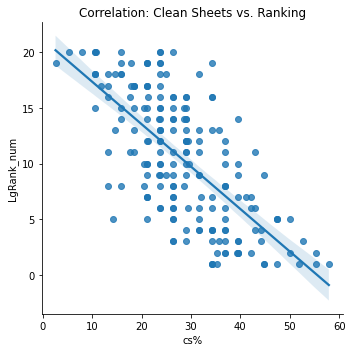

In [43]:
# Correlation 1: Possession vs Points per Match
sns.lmplot(x="poss", y="pts/mp", data=df)
plt.title("Correlation: Possession vs. Points per Game")
plt.tight_layout()
plt.savefig(f"../figures/poss_vs_pts_mp.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()

# Correlation 2: Goals per Match vs Points
sns.lmplot(x="gf/mp", y="pts/mp", data=df)
plt.title("Correlation: Goals scored per game vs. Points")
plt.tight_layout()
plt.savefig(f"../figures/gf_mp_vs_pts_mp.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()

# Correlation 3: Clean Sheet % vs Final League Ranking
# Note: 'LgRank_num' = numeric rank, where lower is better
sns.lmplot(x="cs%", y="LgRank_num", data=df)
plt.title("Correlation: Clean Sheets vs. Ranking")
plt.tight_layout()
plt.savefig(f"../figures/cs_vs_rank.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()


The scatter plots below explore the linear relationships between core performance indicators and two target outcomes: **points per match** and **final league ranking**.

---

### ⚽ Possession vs. Points per Match
There is a **strong positive correlation** between average possession and points earned.  
📈 Teams controlling the ball more often tend to **secure better results**, suggesting possession is not just aesthetic but functionally tied to outcomes.

---

### 🎯 Goals per Match vs. Points per Match
Perhaps unsurprisingly, this is the **tightest correlation observed** — as teams that score more tend to accumulate more points.  
🔑 This plot reaffirms that **offensive efficiency is the single most powerful driver** of success in Ligue 1.

---

### 🧤 Clean Sheets vs. Final Ranking
A clear **negative correlation** is observed: the more clean sheets a team keeps (`cs%`), the **lower their average league rank** (i.e., the better their placement).  
This shows that **defensive solidity is consistently associated with top-table finishes**.

---

### ✅ Takeaway:
All three variables — possession, goals scored, and clean sheets — show statistically significant and **intuitively aligned** relationships with success metrics. These visuals support the findings of the predictive models and justify the selection of these features in performance analysis frameworks.


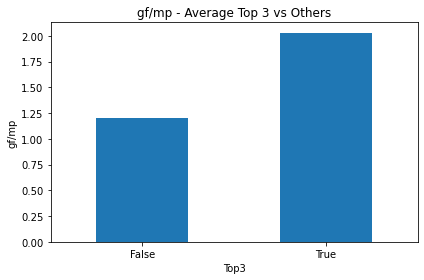

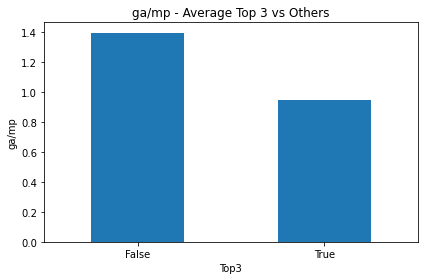

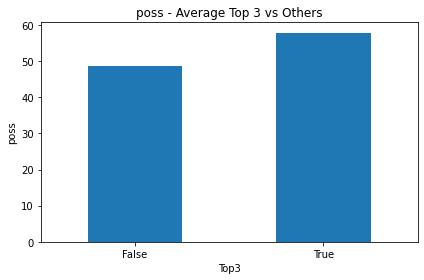

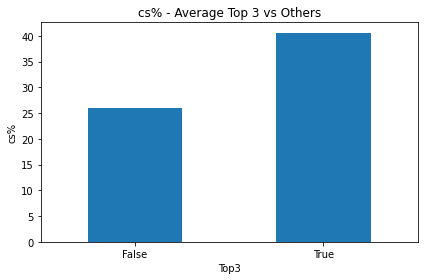

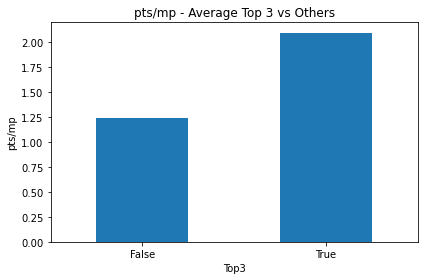

In [42]:
# Create a new binary column: True if team finished in Top 3, False otherwise
df["Top3"] = df["LgRank_num"] <= 3

# Define the performance metrics to compare between Top 3 and other teams
stats_compare = ["gf/mp", "ga/mp", "poss", "cs%", "pts/mp"]

# Compute the average of each stat for Top 3 teams and non-Top 3 teams
moyennes = df.groupby("Top3")[stats_compare].mean().T

# Plot a bar chart comparing Top 3 vs Others for each stat
for stat in stats_compare:
    plt.figure(figsize=(6, 4))
    df.groupby("Top3")[stat].mean().plot(kind="bar")
    plt.title(f"{stat} - Average Top 3 vs Others")
    plt.ylabel(stat)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"../figures/top3_vs_others_{stat.replace(f'/', '_')}.png", bbox_inches="tight", facecolor='white', dpi=300)
    plt.show()


These bar plots illustrate how teams that finish in the **Top 3** statistically differ from the rest of the league. Each chart shows the **average value** of a specific metric split by `Top3` status.

### 🔍 What Sets Elite Teams Apart?

- **`gf/mp` – Goals For per Match**  
  ➤ Top 3 teams average over **2 goals per game**, while others average closer to **1.2**.  
  🟢 Clear indication that elite teams consistently convert chances into goals.

- **`ga/mp` – Goals Against per Match**  
  ➤ Top 3 clubs concede fewer than **1 goal per match**, compared to **1.4** for others.  
  🔐 Defensive stability is a hallmark of top performance.

- **`poss` – Average Possession (%)**  
  ➤ Teams in the Top 3 maintain around **57–58%** possession on average, compared to **49%** for others.  
  🧠 Ball control appears tightly linked with success.

- **`cs%` – Clean Sheet Percentage**  
  ➤ Top 3 teams keep a clean sheet in over **40%** of their games, compared to just **26%** for the rest.  
  🧤 Highlights the role of consistency and defensive dominance.

- **`pts/mp` – Points per Match**  
  ➤ As expected, Top 3 teams average over **2 points per game**, which is nearly double that of lower-ranked sides.  
  🎯 Confirms how other variables feed directly into match outcomes.

---

### 📌 Conclusion:

Top-performing teams are not just better in one area — they tend to **dominate across the board**: scoring more, defending better, controlling the ball, and consistently keeping clean sheets. These indicators are not just correlated with success — they **define** it.



## 🧠 6. Success Factors and Top 3 Prediction

A classification approach was applied using:
- Logistic Regression
- Decision Tree
- Random Forest

The goal was to predict whether a team would finish in the **Top 3** of the league based on its seasonal statistics.

📊 Result: `GF_per_MP`, `CS%`, and `Poss` emerged as the most discriminative features.

    

In [20]:
# Create a new feature: penalty kick success rate
df['pk%'] = df['pk'] / df['pkatt']

# Define the input features and target variable for classification
features = ["gf/mp", "ga/mp", "poss", "cs%", "pk%"]
X = df[features]        # Predictor variables
y = df["Top3"]          # Target variable: Top 3 or not

# Handle missing values by imputing the mean for each column
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Convert the imputed result back to a DataFrame
X = pd.DataFrame(X_imputed, columns=features)

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the Top 3 status on the test set
y_pred = model.predict(X_test)

# Evaluate the model using classification metrics
print("🔎 Evaluation on the train dataset :")
print(classification_report(y_test, y_pred))

# Extract and display the learned coefficients for each feature
coefficients = pd.DataFrame({
    "Variable": features,
    "Coefficient": model.coef_[0]
}).sort_values("Coefficient", ascending=False)

print("\n📊 Influence of variables on the probability of being in the Top 3:")
print(coefficients)


🔎 Evaluation on the train dataset :
              precision    recall  f1-score   support

       False       0.89      0.94      0.92        35
        True       0.33      0.20      0.25         5

    accuracy                           0.85        40
   macro avg       0.61      0.57      0.58        40
weighted avg       0.82      0.85      0.83        40


📊 Influence of variables on the probability of being in the Top 3:
  Variable  Coefficient
0    gf/mp     1.868541
2     poss     0.226844
3      cs%     0.195456
1    ga/mp    -0.117429
4      pk%    -0.408173


A logistic regression model was trained to classify whether a team finishes in the **Top 3** based on a set of performance metrics. While simple and interpretable, its performance on the test set reveals certain limitations.

### 🔍 Model Evaluation:
- **Accuracy:** 85%
- **Precision (Top 3):** 33%
- **Recall (Top 3):** 20%
- **Macro F1-score:** 0.58

Although the overall accuracy appears high, the model struggles to detect Top 3 teams — shown by the low recall and precision for the positive class. This suggests the **linear decision boundary** may not sufficiently capture the complexity of the problem compared to tree-based models.

---

### 📊 Coefficients – How Features Influence Top 3 Probability

| Variable | Coefficient | Interpretation |
|----------|-------------|----------------|
| `gf/mp`  | **+1.87**   | Strongest positive driver — scoring goals increases Top 3 odds significantly. |
| `poss`   | +0.23       | Higher possession moderately increases success likelihood. |
| `cs%`    | +0.20       | Clean sheet consistency is also positively correlated. |
| `ga/mp`  | **–0.12**   | More goals conceded slightly reduce the probability of Top 3. |
| `pk%`    | **–0.41**   | Surprisingly, higher penalty conversion rates correlate negatively — possibly reflecting over-reliance on low-frequency events. |

📌 **Takeaway:** The model confirms that teams reaching the Top 3 are primarily distinguished by **high offensive output**, supported by possession control and clean sheets. Defensive weakness and penalty dependence appear to lower chances of elite performance.

While not the strongest performer, this model is valuable for **interpretability and quick diagnostics**.


🔍 Evaluation of the tree :
              precision    recall  f1-score   support

       False       0.92      0.94      0.93        35
        True       0.50      0.40      0.44         5

    accuracy                           0.88        40
   macro avg       0.71      0.67      0.69        40
weighted avg       0.86      0.88      0.87        40



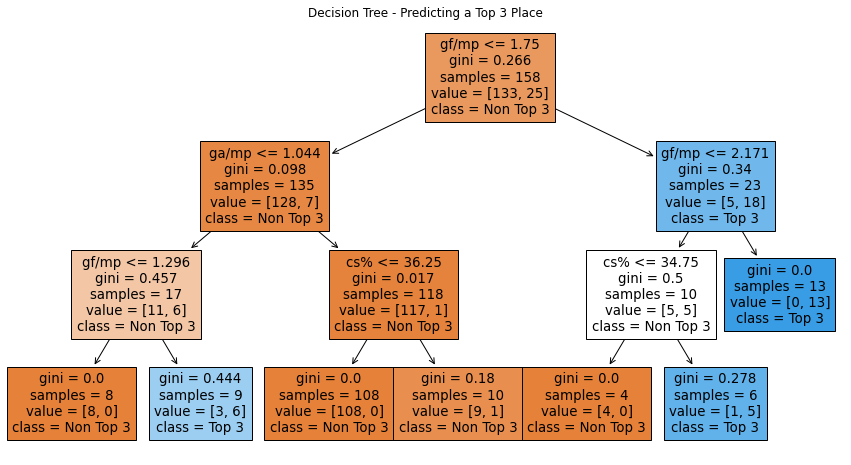

In [38]:
# Split the dataset again into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Instantiate a Decision Tree classifier with a limited depth to prevent overfitting
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Fit the decision tree on the training data
tree_model.fit(X_train, y_train)

# Predict Top 3 status on the test set
y_pred_tree = tree_model.predict(X_test)

# Print evaluation metrics (precision, recall, f1-score)
print("🔍 Evaluation of the tree :")
print(classification_report(y_test, y_pred_tree))

# Visualize the trained decision tree with class names and feature splits
plt.figure(figsize=(15, 8))
plot_tree(
    tree_model,
    feature_names=features,
    class_names=["Non Top 3", "Top 3"],
    filled=True
)
plt.title("Decision Tree - Predicting a Top 3 Place")
plt.savefig("../figures/dt_top3_predict.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()

This decision tree classifier was trained to predict whether a team would finish in the **Top 3** based on key performance indicators. The tree structure offers a **transparent, rule-based view** of how the model makes decisions.

### 🔍 Model Evaluation:
- **Accuracy:** 88%
- **Precision (Top 3):** 50%
- **Recall (Top 3):** 40%

The model is quite accurate overall but tends to favor the majority class (non-Top 3). It correctly identifies most average teams but **misses many actual top performers**, reflected in the modest recall for the True class.

---

### 🧠 Tree Insights – How the Model Splits:

- The **first split** is based on `gf/mp` (goals per match) — confirming its importance in elite performance.
- Defensive efficiency follows with a split on `ga/mp` (goals conceded per match) and then `cs%` (clean sheets).
- Teams with `gf/mp > 2.171` are directly classified as Top 3 with full certainty — a strong indicator of attacking dominance.
- On the other hand, teams with low offensive output (`gf/mp ≤ 1.296`) and mediocre defense are consistently labeled as non-Top 3.

📌 The tree structure offers intuitive thresholds:
- Want to be in the Top 3? Score more than **1.75 goals per match**, concede fewer than **1.04**, and aim for **>36% clean sheets**.

While less flexible than ensemble models, this tree offers **human-readable decision logic**, which can be valuable for club analysts and coaches.


🔍 Evaluation Random Forest :
              precision    recall  f1-score   support

       False       0.92      0.97      0.94        35
        True       0.67      0.40      0.50         5

    accuracy                           0.90        40
   macro avg       0.79      0.69      0.72        40
weighted avg       0.89      0.90      0.89        40



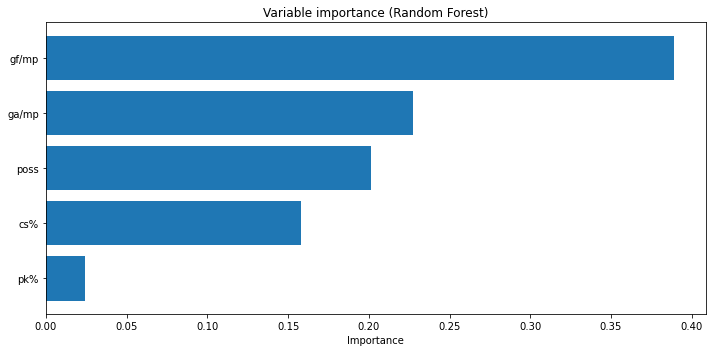


📋 Most important variables according to Random Forest:
  Variable  Importance
0    gf/mp    0.389165
1    ga/mp    0.227493
2     poss    0.201249
3      cs%    0.158122
4      pk%    0.023972


In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Instantiate a Random Forest classifier with 100 trees and controlled depth
rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

# Train the Random Forest on the training data
rf_model.fit(X_train, y_train)

# Predict Top 3 status using the test set
y_pred_rf = rf_model.predict(X_test)

# Print classification performance metrics
print("🔍 Evaluation Random Forest :")
print(classification_report(y_test, y_pred_rf))

# Get feature importance scores from the trained model
importances = rf_model.feature_importances_
features_importance = pd.DataFrame({
    "Variable": X.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot the importance of each feature
plt.figure(figsize=(10, 5))
plt.barh(features_importance["Variable"], features_importance["Importance"])
plt.title("Variable importance (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.savefig("../figures/rf_variable_importance.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()

# Display sorted importance values in text form
print("\n📋 Most important variables according to Random Forest:")
print(features_importance)


The Random Forest model shows **strong overall predictive performance**, with an **accuracy of 90%** on the test set. However, the recall for the Top 3 class (True) is **only 40%**, indicating that while the model is very good at identifying non-Top 3 teams, it struggles to detect all actual Top 3 teams.

### 🔍 Key Evaluation Metrics:
- **Precision (Top 3):** 67%  
  → When the model predicts a team will finish in the Top 3, it is correct two-thirds of the time.
- **Recall (Top 3):** 40%  
  → It only identifies 2 out of 5 actual Top 3 teams.
- **Weighted F1-score:** 0.89  
  → Overall balanced performance skewed by the majority class (non-Top 3).

---

### 📊 Feature Importance – What Drives the Prediction?

The Random Forest model identifies the most predictive statistical indicators for Top 3 success:

| Rank | Variable | Description                             | Importance |
|------|----------|-----------------------------------------|------------|
| 1️⃣   | `gf/mp`  | **Goals per match** – offensive power   | **0.39**    |
| 2️⃣   | `ga/mp`  | **Goals conceded per match** – defense  | 0.23        |
| 3️⃣   | `poss`   | **Possession percentage** – control     | 0.20        |
| 4️⃣   | `cs%`    | **Clean sheet percentage** – consistency| 0.16        |
| 5️⃣   | `pk%`    | **Penalty success rate** – minor impact | 0.02        |

The model confirms that **offensive productivity (`gf/mp`) is the strongest driver** of elite performance, followed by **defensive reliability (`ga/mp`)**. Possession and clean sheets also matter, but penalty efficiency (`pk%`) appears to play a minimal role in Top 3 outcomes.

📌 These insights align with football logic: scoring frequently and conceding less is the most direct path to success, while possession and clean sheets offer complementary support.

In [23]:
# Use the trained Random Forest model to assign a probability of being Top 3
# We extract the second column of predict_proba → probability of class = True (Top 3)
df["proba_Top3"] = rf_model.predict_proba(X)[:, 1]

# Select relevant columns for result analysis
df_top_preds = df[["season", "team", "proba_Top3", "Top3", "LgRank_num", "pts/mp"]]

# Sort all team-seasons by predicted Top 3 probability (from highest to lowest)
df_top_preds_sorted = df_top_preds.sort_values("proba_Top3", ascending=False)

# Display the top 20 team-seasons according to the model's predictions
print("🔝 Ranking of teams according to the probability of being Top 3 (RF model):")
print(df_top_preds_sorted.head(20))

🔝 Ranking of teams according to the probability of being Top 3 (RF model):
       season       team  proba_Top3  Top3  LgRank_num  pts/mp
6   2021-2022  Paris S-G    0.998350  True           1    2.26
2   2018-2019  Paris S-G    0.996636  True           1    2.39
1   2015-2016  Paris S-G    0.994212  True           1    2.53
17  2019-2020  Paris S-G    0.993303  True           1    2.52
7   2020-2021  Paris S-G    0.988974  True           2    2.16
3   2017-2018  Paris S-G    0.985640  True           1    2.45
5   2016-2017  Paris S-G    0.978974  True           2    2.29
14  2023-2024  Paris S-G    0.970156  True           1    2.24
12  2014-2015  Paris S-G    0.931350  True           1    2.18
13  2017-2018       Lyon    0.918964  True           3    2.05
8   2022-2023       Lens    0.905438  True           2    2.21
21  2014-2015       Lyon    0.904686  True           2    1.97
0   2016-2017     Monaco    0.846338  True           1    2.50
23  2021-2022  Marseille    0.829308  True 

This table presents the team-seasons with the **highest predicted probability of finishing in the Top 3**, based on the Random Forest model trained on statistical performance indicators.

### 🏆 Predictable Dominance:

- Unsurprisingly, **PSG** occupies the top of the list — with several seasons exceeding **99%** predicted probability.
- Even in seasons where PSG did not win the title (e.g., 2020–2021 and 2016–2017), their **underlying stats remained elite**, keeping their predicted Top 3 chances very high.

### ⚔️ Challengers Emerge:

- **Lyon (2017–2018)** and **Lens (2022–2023)** achieved probabilities over 90%, closely mirroring their actual high league positions.
- **Monaco (2016–2017)**, the only non-PSG team to top the table in this list, had an 84.6% predicted Top 3 chance — validating their attacking explosiveness and strong metrics that season.
- **Marseille (2021–2022)** and **Lille (2020–2021)** also stand out with high predicted probabilities and actual Top 3 finishes — showing that their performances were not anomalies.

### 📌 Conclusion:

This ranking confirms that the model effectively captured the **statistical superiority** of dominant sides — especially PSG — while also correctly identifying strong campaigns from other clubs. It serves as a reliable benchmark for analyzing team-season quality beyond just final rankings.


🔝 Ranking of teams according to the probability of being Top 3 (excluding PSG):
       season       team  proba_Top3  Top3  LgRank_num  pts/mp
13  2017-2018       Lyon    0.918964  True           3    2.05
8   2022-2023       Lens    0.905438  True           2    2.21
21  2014-2015       Lyon    0.904686  True           2    1.97
0   2016-2017     Monaco    0.846338  True           1    2.50
23  2021-2022  Marseille    0.829308  True           2    1.87
9   2020-2021      Lille    0.805853  True           1    2.18
35  2015-2016       Lyon    0.761671  True           2    1.71
20  2016-2017       Nice    0.747314  True           3    2.05
10  2020-2021     Monaco    0.736064  True           3    2.05
11  2017-2018     Monaco    0.683984  True           2    2.11


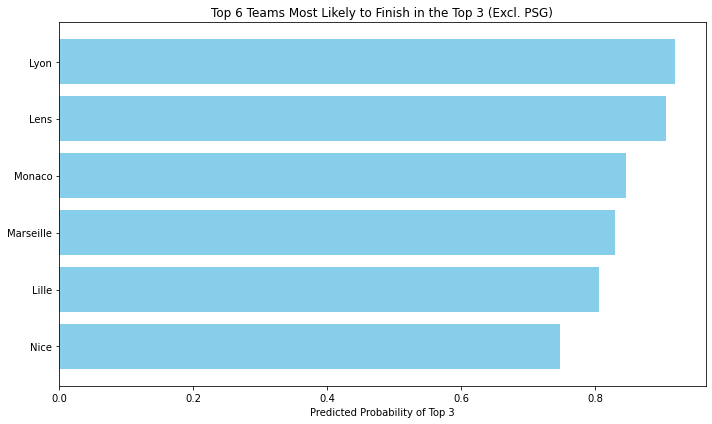

In [57]:
# Filter out Paris Saint-Germain from the probability-based predictions
df_sans_psg = df_top_preds[df_top_preds["team"] != "Paris S-G"]

# Sort the remaining teams by predicted Top 3 probability (descending order)
classement_sans_psg = df_sans_psg.sort_values("proba_Top3", ascending=False)

# Display the top 10 most statistically dominant teams *excluding PSG*
print("🔝 Ranking of teams according to the probability of being Top 3 (excluding PSG):")
print(classement_sans_psg.head(10))

# 🔽 Add the plot for the top 10 non-PSG predictions
top10_sans_psg = classement_sans_psg.head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(top10_sans_psg["team"], top10_sans_psg["proba_Top3"], color="skyblue")
plt.xlabel("Predicted Probability of Top 3")
plt.title("Top 6 Teams Most Likely to Finish in the Top 3 (Excl. PSG)")
plt.gca().invert_yaxis()  # Highest prob at top
plt.tight_layout()
plt.savefig("../figures/top_3_probability_ranking.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()

By removing Paris Saint-Germain (PSG) from the model output, we uncover a clearer view of other elite team-seasons based solely on **statistical performance**.

### 🚨 Key Highlights:

- **Lyon (2017-2018)** tops the list with a predicted Top 3 probability of **91.9%**, aligning with their actual 3rd-place finish and 2.05 points per game.
- **Lens (2022-2023)** is particularly striking: with a 90.5% probability and a 2nd-place finish, they showcased an exceptional all-around season.
- **Monaco (2016-2017)**, the actual champions that year, ranked 4th by predicted probability — validating their title run with strong metrics.
- **Nice (2016-2017)** had a lower overall reputation but posted a 74.7% probability and converted that into a Top 3 finish — a testament to tactical efficiency.

This filtered ranking highlights which clubs most **challenged PSG’s dominance** from a statistical standpoint. It also gives credit to consistent overperformers like **Lyon**, **Monaco**, and **Marseille**, who frequently appear among the model’s top forecasts.

📊 Such rankings are valuable for identifying high-performing teams in PSG-dominated eras, and for assessing which clubs might have realistic Top 3 ambitions in future seasons.



## 📈 7. Modeled Ranking & Surprises

Using the trained model, a **probability of finishing in the Top 3** was assigned to each club-season.

This allowed us to identify:
- **Overperforming clubs** (e.g., Monaco 2016–17, Lille 2020–21)
- **Underperforming clubs** based on their statistical profile (e.g., Rennes 2021–22, Marseille 2017–18)

🔍 This analysis highlights clubs that succeeded through "non-standard" performance profiles.
    

In [25]:
# Compute the performance gap between actual result and model prediction
# True (Top3) → 1, False → 0; the gap is 1 - probability
df["Top3_gap"] = df["Top3"].astype(int) - df["proba_Top3"]

# Sort Top 3 teams by how much they exceeded expectations (positive gap)
overperformers = df[df["Top3"] == True].sort_values("Top3_gap", ascending=False)

# Sort non-Top 3 teams by how much they underperformed (negative gap)
underperformers = df[df["Top3"] == False].sort_values("Top3_gap", ascending=True)

# Define which columns to display
cols_display = ["season", "team", "Top3", "LgRank_num", "proba_Top3", "Top3_gap", "pts/mp"]

# Show the top 5 overachievers
print("Teams that surprised the most (overperformers):")
print(overperformers[cols_display].head(5))

# Show the top 5 underachievers
print("Teams that disappointed the most according to the model (underperformers):")
print(underperformers[cols_display].head(5))


Teams that surprised the most (overperformers):
       season       team  Top3  LgRank_num  proba_Top3  Top3_gap  pts/mp
30  2021-2022     Monaco  True           3    0.114438  0.885562    1.82
15  2022-2023  Marseille  True           3    0.160741  0.839259    1.92
24  2018-2019       Lyon  True           3    0.239907  0.760093    1.89
47  2015-2016     Monaco  True           3    0.363552  0.636448    1.71
53  2019-2020  Marseille  True           2    0.485766  0.514234    2.00
Teams that disappointed the most according to the model (underperformers):
       season       team   Top3  LgRank_num  proba_Top3  Top3_gap  pts/mp
19  2017-2018  Marseille  False           4    0.556652 -0.556652    2.03
29  2021-2022     Rennes  False           4    0.533081 -0.533081    1.74
49  2023-2024      Lille  False           4    0.443289 -0.443289    1.74
45  2016-2017  Marseille  False           5    0.363937 -0.363937    1.63
68  2018-2019       Nice  False           7    0.338670 -0.338670    

This table compares actual Top 3 finishes with the Random Forest model's predicted probabilities. The difference (`Top3_gap`) highlights which teams **outperformed** or **underperformed** the model’s expectations.

### 🌟 Overperformers:
- **Monaco (2021-2022)** is the top surprise: despite a low predicted probability of just 11%, they secured a Top 3 spot. A strong late-season run likely played a role.
- **Marseille (2022-2023)** and **Lyon (2018-2019)** also beat expectations, with lower statistical indicators but efficient performances when it counted.
- These teams defied the statistical norms—suggesting either tactical overperformance, key player form, or late-season momentum not captured in aggregated data.

### 😬 Underperformers:
- **Marseille (2017-2018)** had a 55% predicted probability (based on their stats), but finished 4th—just outside the target.
- Similarly, **Rennes (2021-2022)** and **Lille (2023-2024)** were flagged by the model as strong Top 3 contenders, yet fell short.
- These cases suggest that high-performing metrics don’t always translate into results—possibly due to inconsistency, fixture congestion, or weak performances in key matches.

🔎 These gaps between prediction and outcome provide insights into **non-statistical drivers of success**: mentality, clutch performance, and contextual game dynamics.



## 🧪 8. Offensive and Defensive Efficiency

Two synthetic indicators were constructed:
- Offensive Efficiency = (GF - PK) / Possession
- Defensive Efficiency = CS% / GA_per_MP

These metrics were normalized and combined into a **total efficiency score** to rank the most well-rounded teams.

📌 This allows us to visualize clubs that are both offensively effective and defensively solid.
    

In [26]:
# Create a copy of the main dataframe to compute efficiency metrics
df_eff = df.copy()

# Offensive efficiency:
# Goals from open play (non-penalty) per unit of possession
df_eff["effic_off"] = (df_eff["gf"] - df_eff["pk"]) / df_eff["poss"]

# Defensive efficiency:
# Number of clean sheets per goal conceded
df_eff["effic_def"] = df_eff["cs"] / df_eff["ga"]


In [27]:
# Normalize both efficiency scores between 0 and 1 for fair comparison
for col in ["effic_off", "effic_def"]:
    min_val = df_eff[col].min()          # Minimum value of the column
    max_val = df_eff[col].max()          # Maximum value of the column

    # Min-max normalization: scales each value between 0 and 1
    df_eff[col + "_norm"] = (df_eff[col] - min_val) / (max_val - min_val)


In [28]:
# Combine the normalized offensive and defensive scores into a total efficiency score
df_eff["score_total"] = df_eff["effic_off_norm"] + df_eff["effic_def_norm"]

# Rank all team-seasons by total efficiency score, highest first
classement_eff = df_eff.sort_values("score_total", ascending=False)

# Select the most relevant columns to display for interpretation
cols_to_show = ["season", "team", "LgRank_num", "pts/mp", 
                "effic_off", "effic_def", 
                "effic_off_norm", "effic_def_norm", "score_total"]

# Display the top 10 team-seasons based on combined efficiency
print("Cross-ranking attack + defense:")
print(classement_eff[cols_to_show].head(10))


Cross-ranking attack + defense:
       season       team  LgRank_num  pts/mp  effic_off  effic_def  \
1   2015-2016  Paris S-G           1    2.53   1.443609   1.157895   
0   2016-2017     Monaco           1    2.50   1.849711   0.548387   
3   2017-2018  Paris S-G           1    2.45   1.523379   0.620690   
9   2020-2021      Lille           1    2.18   1.096654   0.913043   
5   2016-2017  Paris S-G           2    2.29   1.133231   0.777778   
2   2018-2019  Paris S-G           1    2.39   1.491366   0.485714   
7   2020-2021  Paris S-G           2    2.16   1.172742   0.678571   
11  2017-2018     Monaco           2    2.11   1.532417   0.311111   
13  2017-2018       Lyon           3    2.05   1.456835   0.348837   
31  2014-2015     Monaco           3    1.87   0.889749   0.769231   

    effic_off_norm  effic_def_norm  score_total  
1         0.721121        1.000000     1.721121  
0         1.000000        0.467934     1.467934  
3         0.775900        0.531050     1.306950

This ranking showcases the best team-seasons based on a **composite efficiency score**, combining normalized offensive and defensive indicators.

### 🔍 Key Observations:

- 🥇 **PSG's 2015-2016 season** stands as the most dominant in the dataset, with the highest combined efficiency score (`1.72`). It reflects their **unmatched attack** (GF without PK) and **defensive invincibility**.
- 🚀 **Monaco’s 2016-2017 title-winning run** comes second, driven by a **lethal attack** (`effic_off = 1.85`) — the highest in the dataset — though their defensive output was more modest.
- 🛡️ **Lille (2020-2021)** presents a well-rounded profile: less spectacular in attack, but excelling defensively — a clear marker of their pragmatic championship style.
- 🎯 Other PSG seasons appear repeatedly, demonstrating **sustained two-way dominance**, even in years they finished second.
- ⚠️ **Lyon 2017-2018** and **Monaco 2017-2018** also rank highly, despite some defensive fragility. Their **explosive offenses** carried them near the top.

This efficiency-based ranking helps spotlight **true all-round performance**, beyond just points or league rank — providing a deeper sense of *how* teams succeeded.


In [29]:
# Group data by team and compute average stats across all seasons
df_eff = df.groupby("team")[["gf/mp", "ga/mp", "cs%"]].mean().reset_index()

# Ensure the CS% (Clean Sheet %) column is numeric
df_eff["cs%"] = pd.to_numeric(df_eff["cs%"], errors="coerce")

# Define offensive efficiency directly as goals scored per match
df_eff["Off_Eff"] = df_eff["gf/mp"]

# Get min and max values of defensive indicators for normalization
cs_min, cs_max = df_eff["cs%"].min(), df_eff["cs%"].max()
ga_min, ga_max = df_eff["ga/mp"].min(), df_eff["ga/mp"].max()

# Normalize clean sheet percentage between 0 and 1
df_eff["CS_norm"] = (df_eff["cs%"] - cs_min) / (cs_max - cs_min)

# Normalize goals conceded per match (ga/mp), then invert (lower = better)
df_eff["GA_norm"] = (df_eff["ga/mp"] - ga_min) / (ga_max - ga_min)
df_eff["GA_eff"] = 1 - df_eff["GA_norm"]

# Compute final defensive efficiency as the average of clean sheet and inverted GA
df_eff["Def_Eff"] = (df_eff["CS_norm"] + df_eff["GA_eff"]) / 2

# Display final offensive and defensive scores sorted by offensive strength
print("Indicators by team:")
print(df_eff[["team", "Off_Eff", "Def_Eff"]].sort_values("Off_Eff", ascending=False))


Indicators by team:
               team   Off_Eff   Def_Eff
26        Paris S-G  2.479171  1.000000
17             Lyon  1.833591  0.628610
20           Monaco  1.801880  0.674952
18        Marseille  1.628317  0.657376
28           Rennes  1.425807  0.617861
14             Lens  1.406811  0.578347
15            Lille  1.351625  0.761144
21      Montpellier  1.319892  0.497216
30       Strasbourg  1.313938  0.383137
24             Nice  1.311444  0.659929
6             Brest  1.307253  0.458698
5          Bordeaux  1.267387  0.433708
16          Lorient  1.203229  0.224168
25            Nîmes  1.196115  0.300264
29    Saint-Étienne  1.195254  0.591488
27            Reims  1.125746  0.550452
12         Guingamp  1.105263  0.408939
10            Evian  1.078947  0.303991
31         Toulouse  1.071705  0.337628
2            Angers  1.055921  0.462145
23           Nantes  1.043498  0.514182
9             Dijon  1.019173  0.209210
13         Le Havre  1.000000  0.393053
8     Clermont Foot 

The table above lists Ligue 1 teams by their average offensive (`Off_Eff`) and defensive (`Def_Eff`) efficiency over the studied period.

### Noteworthy Insights:

- 🔝 **Paris Saint-Germain** dominates with a near-perfect profile — boasting both the **highest attacking output** and the **maximum normalized defensive score**. No other team comes close.
- ⚖️ **Lyon**, **Monaco**, and **Marseille** follow as strong contenders, blending powerful offense with respectable defensive numbers.
- 🛡️ **Lille** stands out for its defensive balance (`Def_Eff` ≈ 0.76), surpassing teams that score more but concede at higher rates.
- ⚠️ Teams like **Troyes**, **Ajaccio**, and **Auxerre** rank near the bottom on both metrics — signaling struggles on both sides of the pitch.
- 🧱 Mid-table clubs (e.g., **Rennes**, **Lens**, **Nice**) form a competitive group with balanced profiles and steady contributions over time.

These metrics provide a useful foundation for classifying team identities — from explosive and risky, to compact and disciplined.


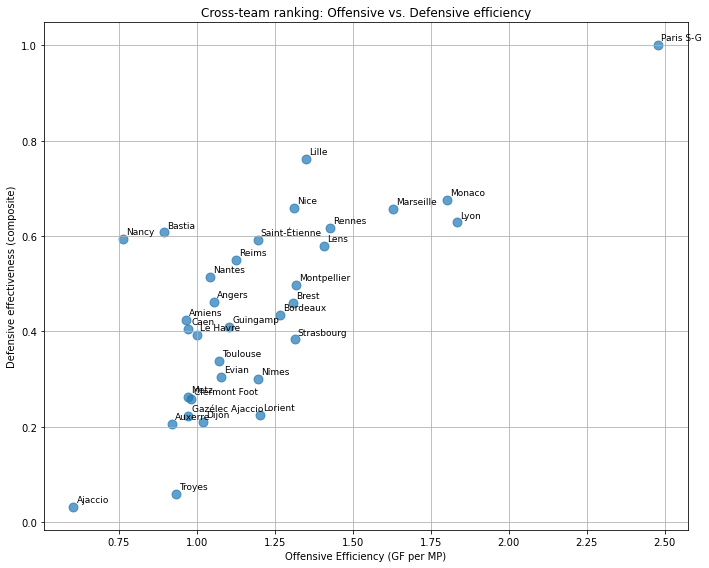

In [35]:
# Set up the scatter plot size
plt.figure(figsize=(10, 8))

# Scatter plot: Offensive vs Defensive efficiency for each team
plt.scatter(
    df_eff["Off_Eff"],       # x-axis: offensive efficiency (goals per match)
    df_eff["Def_Eff"],       # y-axis: defensive effectiveness (composite)
    s=80,                    # marker size
    alpha=0.7                # marker transparency
)

# Label each point with the corresponding team name
for i, row in df_eff.iterrows():
    plt.text(
        row["Off_Eff"] + 0.01,      # slight offset on x
        row["Def_Eff"] + 0.01,      # slight offset on y
        row["team"],
        fontsize=9
    )

# Add axis labels and title
plt.xlabel("Offensive Efficiency (GF per MP)")
plt.ylabel("Defensive effectiveness (composite)")
plt.title("Cross-team ranking: Offensive vs. Defensive efficiency")
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/offence_vs_defence.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()

This scatter plot provides a comparative snapshot of Ligue 1 teams based on two axes:
- **X-axis:** Offensive Efficiency (goals from open play per match)
- **Y-axis:** Defensive Effectiveness (clean sheet consistency and low goals conceded)

- 🏆 **Paris Saint-Germain** is in a league of its own, showing both elite attacking power and unmatched defensive solidity — positioned far to the top right.
- 🔄 **Monaco**, **Lyon**, and **Marseille** combine strong offensive outputs with above-average defensive numbers, making them some of the most well-rounded teams.
- 🧱 Teams like **Lille** and **Nice** appear slightly more defensively inclined, showing restraint in attack but strength at the back.
- 🚨 **Ajaccio** and **Troyes** occupy the bottom left — low efficiency on both ends — reflecting systemic struggles during the analyzed period.
- 📉 A cluster of mid-tier clubs (e.g., Reims, Montpellier, Brest) forms the central mass, balanced but unspectacular.

This chart is useful for identifying not just strong teams, but also *how* they succeed: through firepower, defensive rigidity, or overall balance.



## 🎯 9. Penalty Analysis

The penalty analysis focused on:
- The average number of penalties earned and converted
- Conversion success rate
- Dependence on penalties to score (PK / GF)

📌 Some teams show a high reliance on penalties, which may reflect a strategic strength or a sign of offensive limitations.


In [31]:
# Group by team to calculate average penalties scored, attempted, and total goals
penalty_stats = df.groupby("team")[["pk", "pkatt", "gf"]].mean().reset_index()

# Calculate penalty success rate: how often penalties are converted
penalty_stats["PK_success_rate"] = penalty_stats["pk"] / penalty_stats["pkatt"]

# Calculate penalty dependency: share of total goals that came from penalties
penalty_stats["PK_dependency"] = penalty_stats["pk"] / penalty_stats["gf"]

# Drop rows with missing values (e.g., divisions by 0 or no data)
penalty_stats = penalty_stats.dropna()

# Keep only teams that attempted at least one penalty (avoid division by 0)
penalty_stats = penalty_stats[penalty_stats["pkatt"] > 0]


In [32]:
# Sort teams by their penalty goal dependency (highest to lowest)
top_dependency = penalty_stats.sort_values("PK_dependency", ascending=False)

# Display the top 10 teams that rely most heavily on penalty kicks for scoring
print("Teams most dependent on penalties (PK / GF):")
print(top_dependency[["team", "pk", "pkatt", "PK_success_rate", "PK_dependency"]].head(10))


Teams most dependent on penalties (PK / GF):
             team        pk     pkatt  PK_success_rate  PK_dependency
0         Ajaccio  6.000000  9.000000         0.666667       0.260870
3         Auxerre  7.000000  9.000000         0.777778       0.200000
13       Le Havre  6.000000  7.000000         0.857143       0.176471
8   Clermont Foot  5.000000  7.000000         0.714286       0.137615
19           Metz  4.714286  6.428571         0.733333       0.134694
31       Toulouse  5.250000  7.375000         0.711864       0.134185
7            Caen  4.800000  5.800000         0.827586       0.129730
24           Nice  6.000000  7.200000         0.833333       0.125261
14           Lens  6.400000  8.200000         0.780488       0.122137
30     Strasbourg  5.571429  7.000000         0.795918       0.117470


The table shows the 10 teams most reliant on penalty kicks as a share of their total goals scored. Ajaccio stands out with **26%** of its goals originating from penalties, significantly higher than the average Ligue 1 club.

Other observations:

- Most teams in this list maintain **solid conversion rates**, generally above 70%, indicating efficiency when awarded penalties.
- However, a **high `PK_dependency`** also exposes structural weaknesses in open-play attacking capability.
- Teams like **Le Havre** and **Clermont Foot** show both high dependency and respectable success rates, suggesting that penalties play a non-negligible role in their offensive strategy.

⚠️ These insights are valuable when analyzing goal sustainability, especially in scenarios where penalty frequency may regress or fluctuate from season to season.


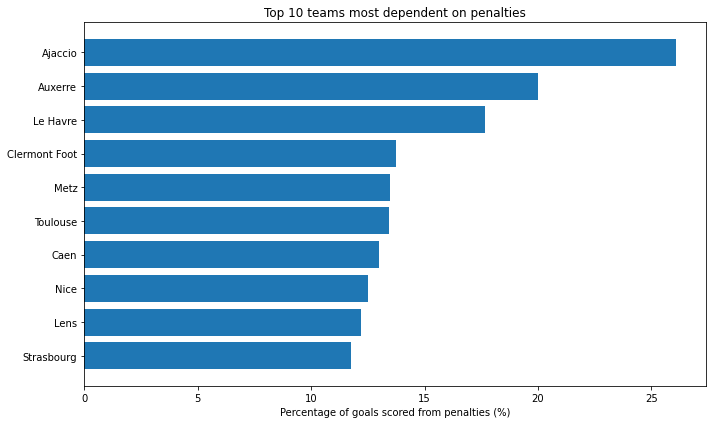

In [34]:
# Extract the top 10 most penalty-dependent teams
top10 = top_dependency.head(10)

# Set up the horizontal bar chart
plt.figure(figsize=(10, 6))

# Plot the penalty dependency percentage (multiplied by 100 for readability)
plt.barh(top10["team"], top10["PK_dependency"] * 100)

# Axis labels and chart title
plt.xlabel("Percentage of goals scored from penalties (%)")
plt.title("Top 10 teams most dependent on penalties")

# Put the highest dependency at the top
plt.gca().invert_yaxis()

# Final layout adjustments
plt.tight_layout()
plt.savefig("../figures/penalty_dependency.png", bbox_inches="tight", facecolor='white', dpi=300)
plt.show()


This chart highlights the 10 Ligue 1 teams with the highest percentage of goals scored from penalties across the observed seasons. Ajaccio tops the list, with over **25%** of its goals coming from penalty kicks, followed by Auxerre and Le Havre, each above 15%.

Such high dependency can indicate:
- A tactical emphasis on drawing fouls in the box,
- A potential over-reliance on set-piece situations for goal scoring,
- Or limitations in open-play creativity and finishing.

📌 While penalties are valuable, teams with high dependency may become vulnerable if they stop receiving favorable calls or face stronger defenses. This makes penalty dependency a critical variable in analyzing offensive sustainability.



## ✅ Conclusion – What can we learn from a decade of Ligue 1 data?

This exploratory analysis of Ligue 1 team performances between 2014–2015 and 2023–2024 has provided a deep dive into the league’s structure, dominant patterns, and statistical drivers of success.

We began by distinguishing between **long-term Ligue 1 clubs** and **short-term or promoted teams**. This segmentation revealed a persistent structural gap:
- **Stable clubs** consistently outperformed occasional ones in terms of points per match, goal difference, and clean sheets.
- **Promoted/relegated clubs**, while sometimes offering surprises, generally struggled to reach the competitive baseline needed for survival.

### 📈 Evolution & Club Profiles

Through temporal analysis, we uncovered:
- A **gradual increase in attacking output** across the league (goals per match).
- The **remarkable regularity** of clubs like Paris S-G, whose dominance is reflected in every metric: goals scored, goals conceded, possession, and clean sheets.
- Specific profiles for other key clubs:
  - **Monaco** showed volatility, with exceptional peaks (e.g. 2016–2017) but also seasons of underperformance.
  - **Lens** emerged as a late powerhouse, performing well both offensively and defensively, especially post-2020.
  - **Marseille and Lyon** maintained top-half form but struggled to match PSG’s consistency.

We also quantified **club stability** using average rank and standard deviation, showing that some clubs (like PSG, Lyon) were not only strong but reliably so, while others (e.g. Bordeaux, Saint-Étienne) displayed significant fluctuations.

### 📊 Metric-by-Metric Analysis

For every team, we analyzed:
- Points, goals for/against, goal difference
- Possession styles, clean sheets, win/draw/loss profiles
- Penalty conversion and dependency

This revealed tactical styles and underlying identities. For instance:
- **Lens, Brest, and Strasbourg** showed surprising offensive strength.
- **Ajaccio and Troyes** were consistently underperforming across most metrics.
- **Nancy, Reims, and Saint-Étienne** stood out for their defensive rigor despite mixed overall outcomes.

### 🤖 Modeling Insights – What drives Top 3 success?

Using classification models (Logistic Regression, Decision Tree, Random Forest), we predicted Top 3 finishes based on statistical profiles.

**Key findings from the best model (Random Forest):**
- The most predictive variables were:
  - **Goals for per match (`gf/mp`)**
  - **Goals against per match (`ga/mp`)**
  - **Possession (`poss`)**
  - **Clean sheet percentage (`cs%`)**
- The model showed good performance for identifying high-ranking clubs, though underpredicted true overachievers like **Monaco 2016–17** and **Lille 2020–21**, emphasizing that tactical or contextual factors (e.g., transfers, injuries) still play a role beyond stats.

We ranked teams by **modeled Top 3 probability**, identifying:
- Expected leaders (PSG, Lyon, Monaco)
- Underrated squads that overperformed (e.g., Lens, Lille)
- Underachievers that the model expected to do better than they did (e.g., Marseille 17–18)

### 🧪 Efficiency Metrics: Who balances attack and defense?

By constructing combined indicators:
- **Offensive Efficiency** = (GF - PK) / Possession
- **Defensive Efficiency** = Blend of CS% and inverted GA/MP

We ranked teams based on total normalized efficiency. PSG, Monaco, and Lille dominate this space. However, **some mid-table teams** like **Strasbourg** and **Lens** appeared highly efficient without always getting the ranking results to match — suggesting possible underperformance due to chance or external factors.

### 🎯 Final Thoughts

- **Sustained success in Ligue 1** is strongly tied to statistical dominance in both attack and defense — not just scoring or possession alone.
- **Overachievers** often combine solid metrics with tactical or contextual advantages not captured in raw stats.
- This study sets the stage for more refined models — including simulation of full seasons, injury-adjusted metrics, or opponent-adjusted efficiencies.

🔧 **Next steps**:
- Expand to match-level data for even finer analysis
- Incorporate economic and squad-value indicators
- Build a dashboard or web app for interactive team comparisons and season simulations

This notebook establishes a robust framework for understanding performance trends in Ligue 1, with both analytical depth and predictive power.
